# Case Fraudes Meli

## EDA

### Avaliando Bad-Rate da base

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
import numpy as np

<Figure size 640x480 with 0 Axes>

In [2]:
import unicodedata

In [3]:
from sklearn.decomposition import PCA

In [4]:
import scipy.sparse

In [5]:
df = pd.read_csv('dados.csv')

In [6]:
df.head(2)

a       b         c     d         e     f   g  h  \
0  4  0.7685  94436.24  20.0  0.444828   1.0  BR  5   
1  4  0.7550   9258.50   1.0  0.000000  33.0  BR  0   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Avental Descartavel Manga Longa  - 50 Un. Tnt ...  cat_64b574b  0.376019   

        l      m  n    o  p                fecha   monto  score  fraude  
0   240.0  102.0  1  NaN  N  2020-03-27 11:51:16    5.64     66       0  
1  4008.0    0.0  1    Y  N  2020-04-15 19:58:08  124.71     72       0

In [7]:
df.fraude.value_counts(normalize=True)

fraude
0    0.95
1    0.05
Name: proportion, dtype: float64

Criando colunas auxiliares de data para avaliação de comportamentos ao longo do tempo

In [8]:
df['fecha'].isna().sum()

0

In [9]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [10]:
df['ymd'] = df['fecha'].dt.strftime('%Y%m%d').astype(int)

In [11]:
df['week'] = df['fecha'].dt.isocalendar().week.astype(int)

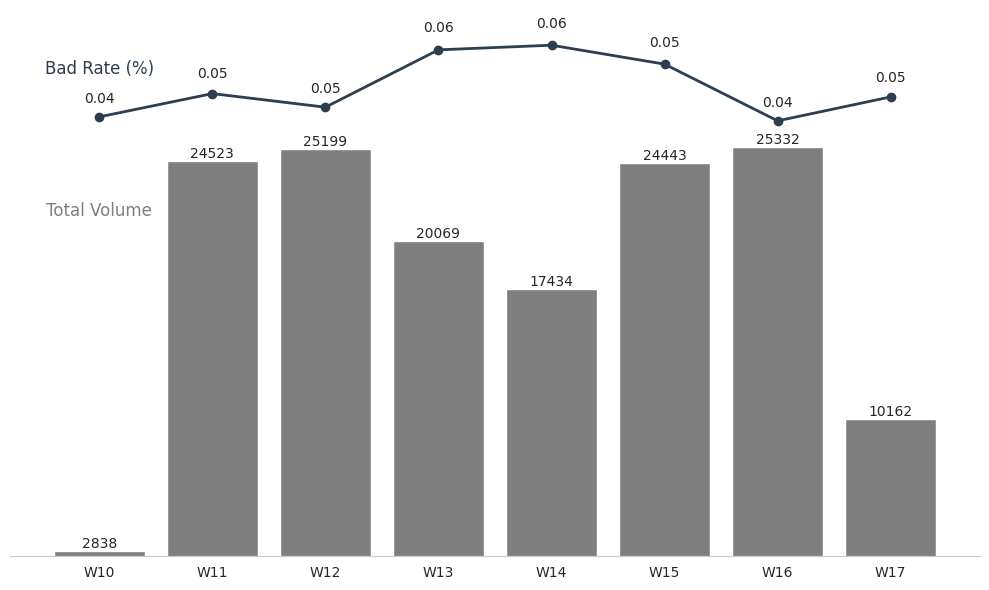

In [12]:
# Agrupa os dados por 'week'
weekly_volume = df.groupby('week')['fraude'].count().sort_index()
weekly_bad_rate = df.groupby('week')['fraude'].mean().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Define cores neutras e profissionais
bar_color = '#7f7f7f'
line_color = '#2c3e50'

# Plota o gráfico de barras e a linha (a linha fica sobre as barras com zorder)
bars = ax1.bar(weekly_volume.index, weekly_volume.values, color=bar_color, zorder=1)
ax2.plot(weekly_bad_rate.index, weekly_bad_rate.values, color=line_color, marker='o', linewidth=2, zorder=5)

# Remove ticks e rótulos dos eixos y (esquerdo e direito)
ax1.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False, right=False, labelright=False)

# Remove as bordas e grids
for ax in (ax1, ax2):
    for spine_key, spine in ax.spines.items():
        if spine_key != 'bottom':
            spine.set_visible(False)
    ax.grid(False)

# Define os rótulos do eixo x com 'W' antes do número da semana
ax1.set_xticks(weekly_volume.index)
ax1.set_xticklabels([f"W{x}" for x in weekly_volume.index])

# Anota os números no topo de cada barra
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
             str(int(height)), ha='center', va='bottom', fontsize=10)

# Anota os valores do bad rate próximos aos marcadores da linha
for x, y in zip(weekly_bad_rate.index, weekly_bad_rate.values):
    ax2.text(x, y+y*0.05, f"{y:.2f}", ha='center', va='bottom', fontsize=10)

# Adiciona rótulos explicativos: "Total Volume" próximo ao gráfico de barras...
mid_index = weekly_volume.index[0]
max_volume = weekly_volume.max() - weekly_volume.max()*0.2
ax1.text(mid_index, max_volume * 1.05, "Total Volume", ha='center', va='bottom', fontsize=12, color='#7f7f7f')

# ...e "Bad Rate (%)" próximo à linha
last_week = weekly_bad_rate.index[0]
last_rate = weekly_bad_rate.values[-1]
ax2.text(last_week, last_rate * 1.08, "Bad Rate (%)", ha='center', va='bottom', fontsize=12, color='#2c3e50')


ax1.set_ylim(weekly_volume.min()-weekly_volume.min()*0.1,
             weekly_volume.max()+weekly_volume.max()*0.3)
ax2.set_ylim(weekly_bad_rate.min()-weekly_bad_rate.min()*2.0,
             weekly_bad_rate.max()+weekly_bad_rate.max()*0.12)


plt.tight_layout()
plt.show()

In [13]:
df['OOT'] = 'train'
df.loc[df['week'].isin([15, 16, 17]), 'OOT'] = 'test'

#### Evaluating bad rate from train and test

In [14]:
df.groupby('OOT').fraude.value_counts(normalize=True)

OOT    fraude
test   0         0.951733
       1         0.048267
train  0         0.948847
       1         0.051153
Name: proportion, dtype: float64

Bad rate seems reasonable and stable

##### Evaluating percentage of each OOT

In [15]:
df['OOT'].value_counts(normalize=True)

OOT
train    0.60042
test     0.39958
Name: proportion, dtype: float64

A little bit more than usual for testing, but might be enough for this case, and good to ensure the model would perform well in production

### Evaluating features

gráfico para avaliar missings ao longo do tempo

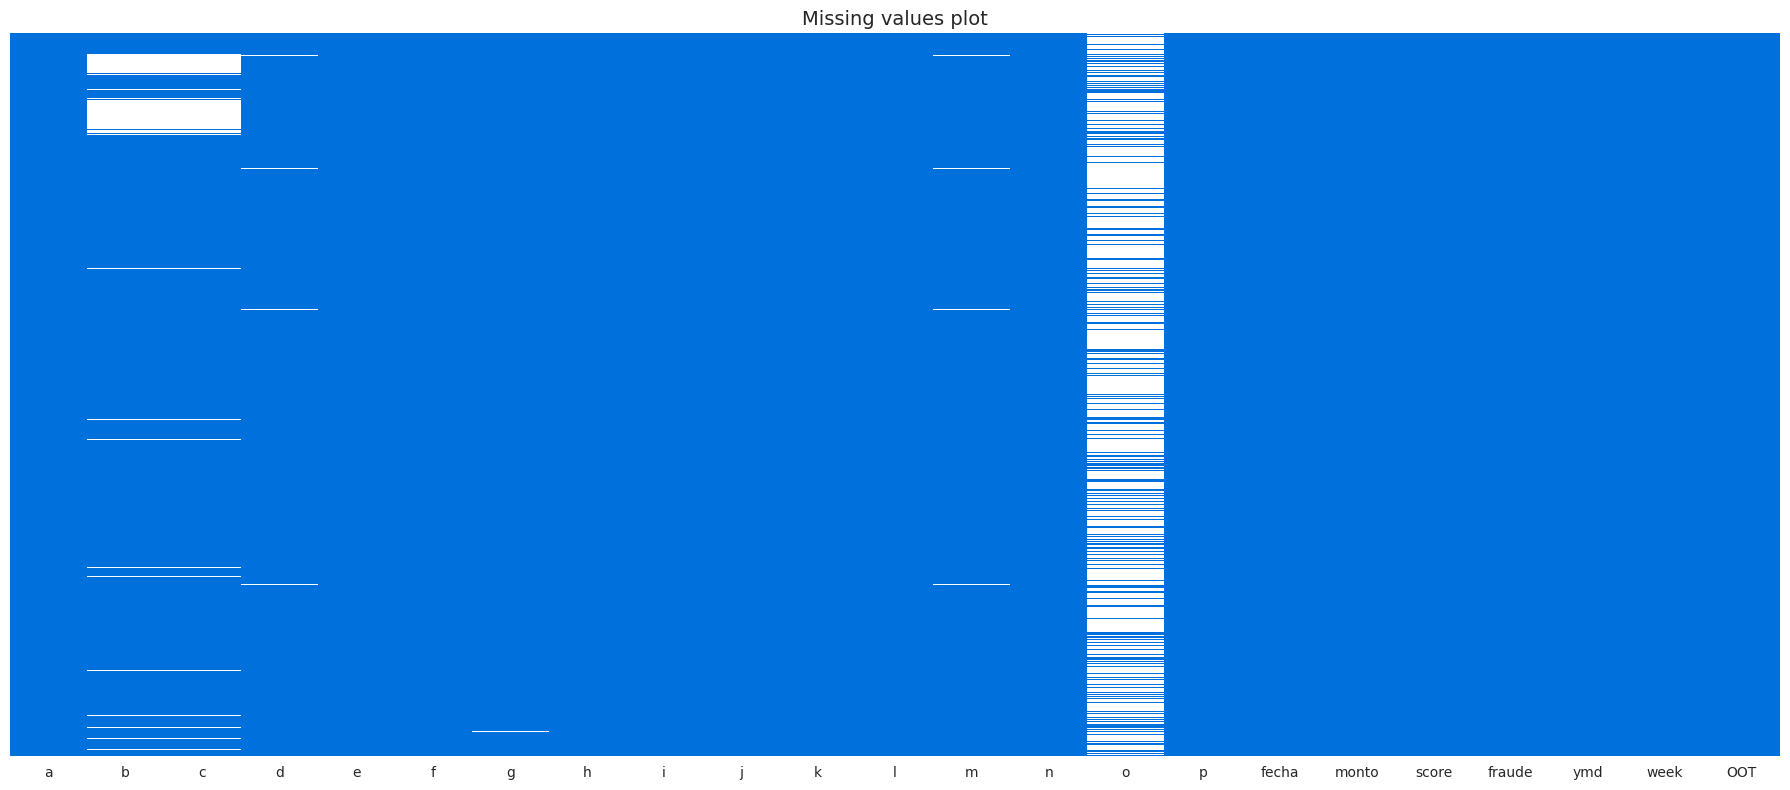

In [16]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(df.sort_values('fecha').isna(),
            ax=ax,
            cbar=False,
            yticklabels=False,
            cmap=['#0071dc','white'])
plt.xticks(rotation=0)
plt.title('Missing values plot',fontdict={'fontsize':14})
plt.tight_layout()
plt.show()

**Observações**
* 'b'e 'c' seguem o mesmo padrão de missings e demonstram correlação com um período específico
* a var 'o' tem muitos missings ao longo do tempo


---


**Comentários**
* Mesma estratégia para lidar com os missings de 'b' e 'c'
* Avaliar se a variável 'o' pode ser utilizada mesmo com tantos missings


In [17]:
def check_bad_var_compare(df, var, target, week_filter1, week_filter2, tipo='auto', ascending=False, cut=10):
    def process_data(df_filtered):
        df_copy = df_filtered.copy()
        df_copy["tot_qtd"] = -1

        if tipo == "categorica":
            df2 = df_copy.groupby(var).agg({'tot_qtd': 'count', target: 'sum'}).reset_index()
        else:
            if not np.issubdtype(df_copy[var].dtype, np.number):
                raise ValueError(f"A coluna '{var}' precisa ser numérica para usar qcut.")

            unique_values = df_copy[var].nunique()
            bins = cut  # Use the provided cut value
            if unique_values < bins:
                bins = unique_values

            # Create bins using qcut
            df_copy[var] = pd.qcut(df_copy[var], bins, duplicates='drop')
            df2 = df_copy.groupby(var, observed=True).agg({'tot_qtd': 'count', target: 'sum'}).reset_index()

            # *** Sort the DataFrame while 'var' is still of Interval type ***
            df2 = df2.sort_values(by=var, ascending=ascending)

            # *** Convert the sorted intervals to strings for display purposes ***
            df2[var] = df2[var].astype(str)

        df2["BP"] = round(10000 * df2[target] / df2["tot_qtd"], 3)
        bp_mean = round(10000 * df2[target].sum() / df2["tot_qtd"].sum(), 3)
        return df2, bp_mean

    df_week1 = df[df['week'].isin(week_filter1)]
    df_week2 = df[df['week'].isin(week_filter2)]

    df2_1, bp_mean1 = process_data(df_week1)
    df2_2, bp_mean2 = process_data(df_week2)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    for ax, df2, bp_mean, title in zip(axes, [df2_1, df2_2], [bp_mean1, bp_mean2],
                                        [f'Semanas {week_filter1}', f'Semanas {week_filter2}']):
        ax2 = ax.twinx()
        x_labels = df2[var].astype(str)
        x_positions = np.arange(len(x_labels))

        ax.bar(x_positions, df2["tot_qtd"], color="#BFE1FF", label="Volume")
        ax2.plot(x_positions, df2["BP"], color="#FF6D07", marker='o', linestyle='-', label="BP")
        ax2.axhline(y=bp_mean, color="r", linestyle="--", label="Média BP")

        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel("Volume")
        ax2.set_ylabel("BP")
        ax.set_title(title)
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")

        ax.grid(False)
        ax2.grid(False)

    plt.tight_layout()
    plt.show()

#### Analisando a variável a

##### Analise inicial

In [18]:
df.a.head(5).reset_index().T

0  1  2  3  4
index  0  1  2  3  4
a      4  4  4  4  2

In [19]:
df.a.value_counts(normalize=True).reset_index().T

0         1         2         3
a           4.000000  2.000000  1.000000  3.000000
proportion  0.857193  0.095853  0.027967  0.018987

Aparenta ser categórica, ou talvez uma nota de 1 a 4

##### Análise de nulos

In [20]:
df.a.isna().sum()

0

Sem nulos

##### Análise de estabilidade X BP

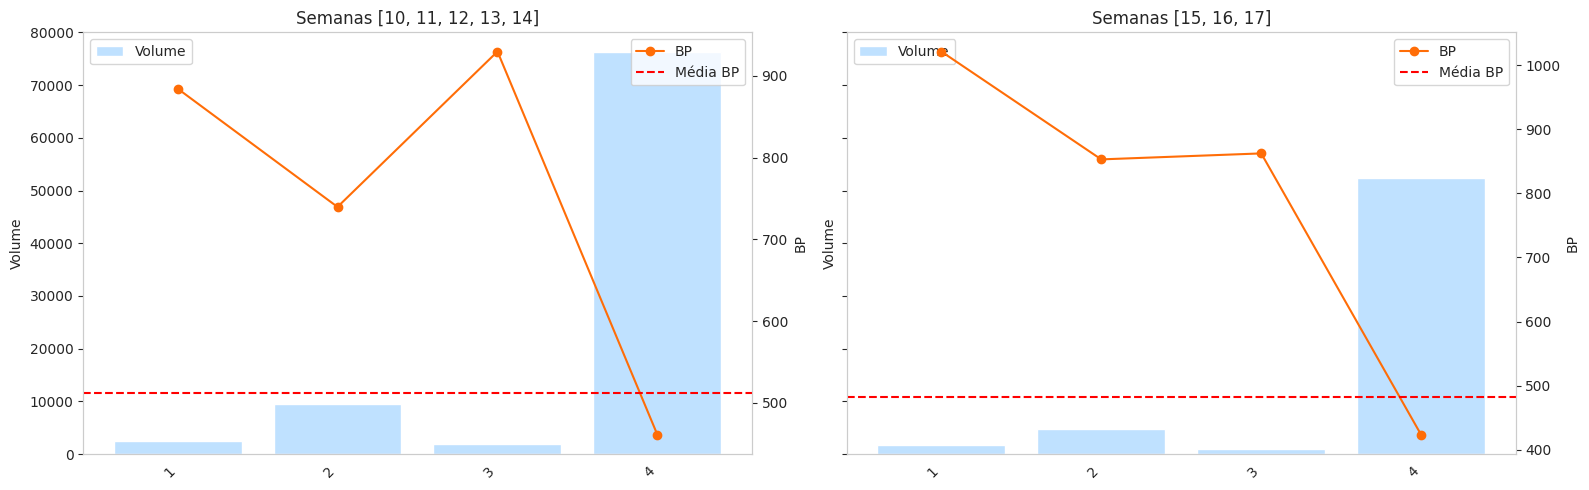

In [21]:
check_bad_var_compare(df, var='a', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

**Observações**
* Variável demonstra uma relativa flutuação do BP
* Valores 1,2,3 demonstram BP relativamente elevado apesar do baixo volume
* Valor 4 apresenta alto volume porém BP baixo


---


**Comentários**
* Poderia ser uma ideia simplificar a váriavel e tornar em binária cortando entre 3,4
* Apesar da leve flutuação do BP no tempo os valores que discriminam a fraude se mantém



#### alisando a variável b

##### Análise inicial

In [22]:
df.b.head(5).reset_index().T

0      1       2       3       4
index  0.0000  1.000  2.0000  3.0000  4.0000
b      0.7685  0.755  0.7455  0.7631  0.7315

In [23]:
df.b.describe().reset_index().T

0         1         2    3       4       5       6    7
index     count      mean       std  min     25%     50%     75%  max
b      137016.0  0.728115  0.132943  0.0  0.6784  0.7555  0.8065  1.0

Aparenta ser numerica, continua e vai de 0 a 1

##### Análise de nulos

In [24]:
df.b.isna().sum()

12984

In [25]:
(df.b.isna().sum()/df.b.isna().count())*100

8.656

In [26]:
print('Train:',(df[df['OOT']=='train'].b.isna().sum()/df[df['OOT']=='train'].b.isna().count())*100)
print('Test:',(df[df['OOT']=='test'].b.isna().sum()/df[df['OOT']=='test'].b.isna().count())*100)

Train: 13.826987775224008
Test: 0.8859302267380749


In [27]:
missing_stats = df.groupby('week').agg(
    total_count=('b', 'size'),
    missing_count=('b', lambda x: x.isnull().sum())
).reset_index()

In [28]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

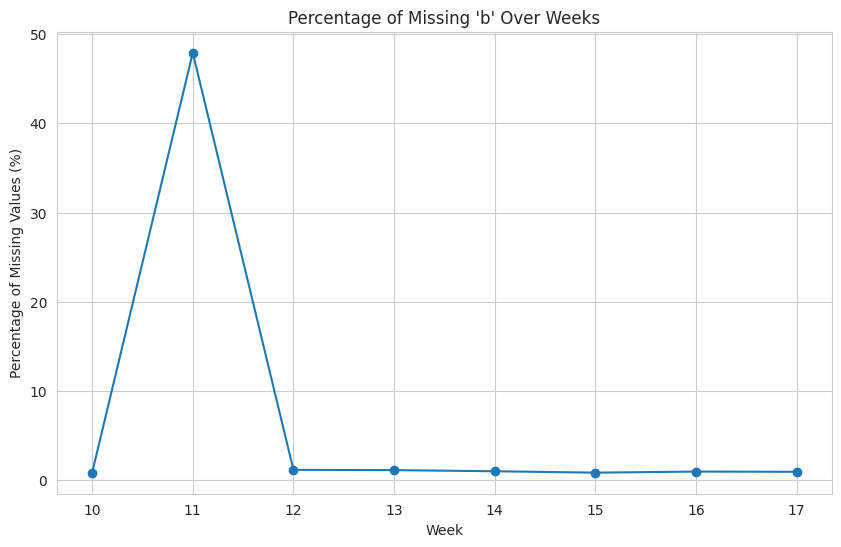

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'b' Over Weeks")
plt.grid(True)
plt.show()

In [30]:
missing_per_day_week_11 = (
    df[df['week'].isin([10, 11, 12, 13])]
    .groupby('ymd')
    .agg(
        missing_count=('b', lambda x: x.isnull().sum()),
        total_count=('b', 'size')
    )
    .reset_index()
)


In [31]:
missing_per_day_week_11['missing_percentage'] = (
    missing_per_day_week_11['missing_count'] / missing_per_day_week_11['total_count'] * 100
)

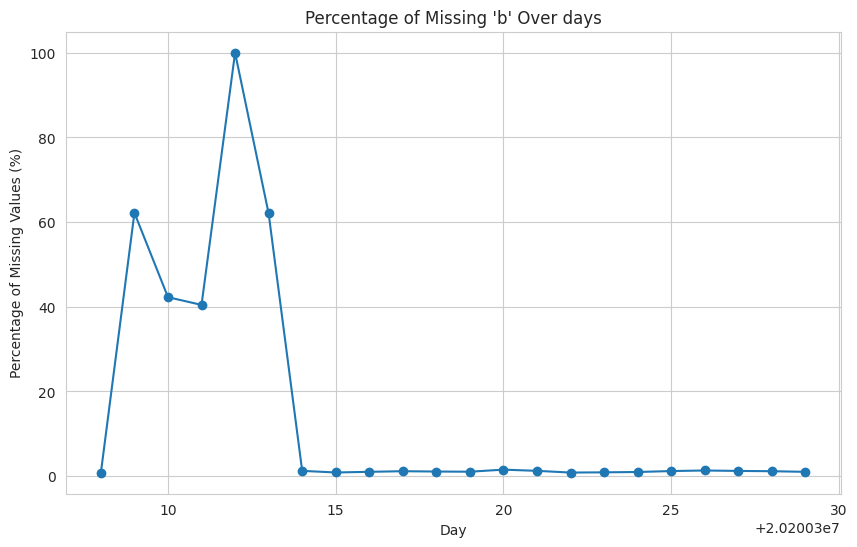

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(missing_per_day_week_11['ymd'], missing_per_day_week_11['missing_percentage'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'b' Over days")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

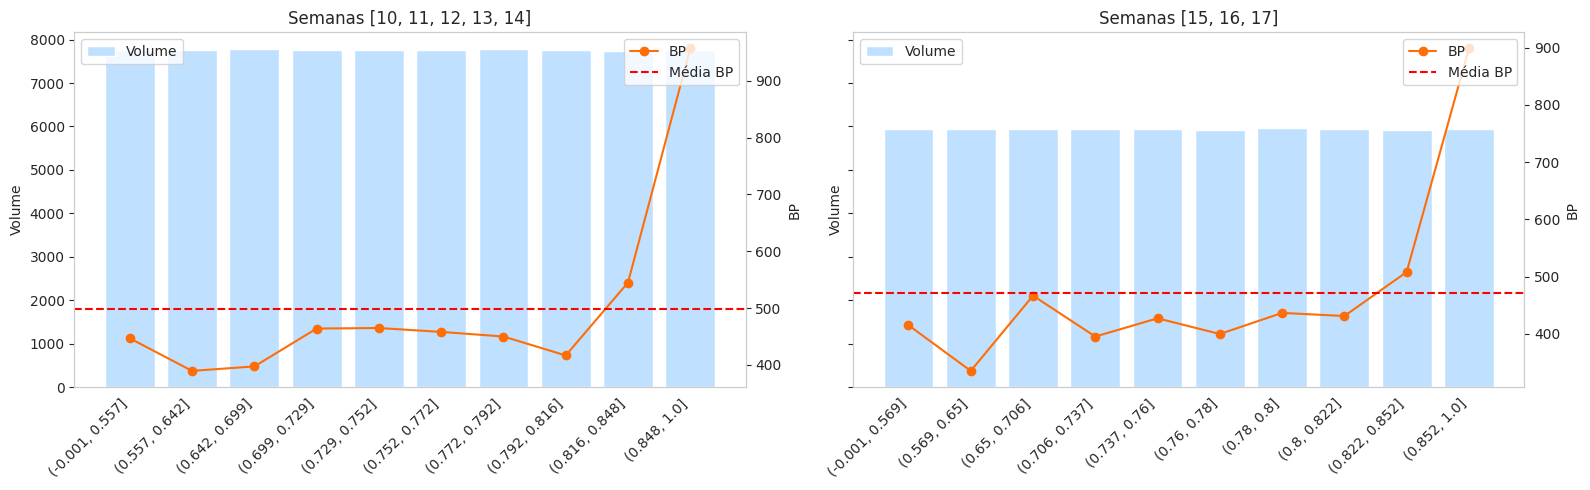

In [33]:
check_bad_var_compare(df, var='b', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [34]:
df['b_filled'] = df['b'].fillna(-1)

In [35]:
df[df['b_filled'] > 0]['fraude'].value_counts(normalize = True)

fraude
0    0.951503
1    0.048497
Name: proportion, dtype: float64

In [36]:
df[df['b_filled'] < 0]['fraude'].value_counts(normalize = True)

fraude
0    0.936152
1    0.063848
Name: proportion, dtype: float64

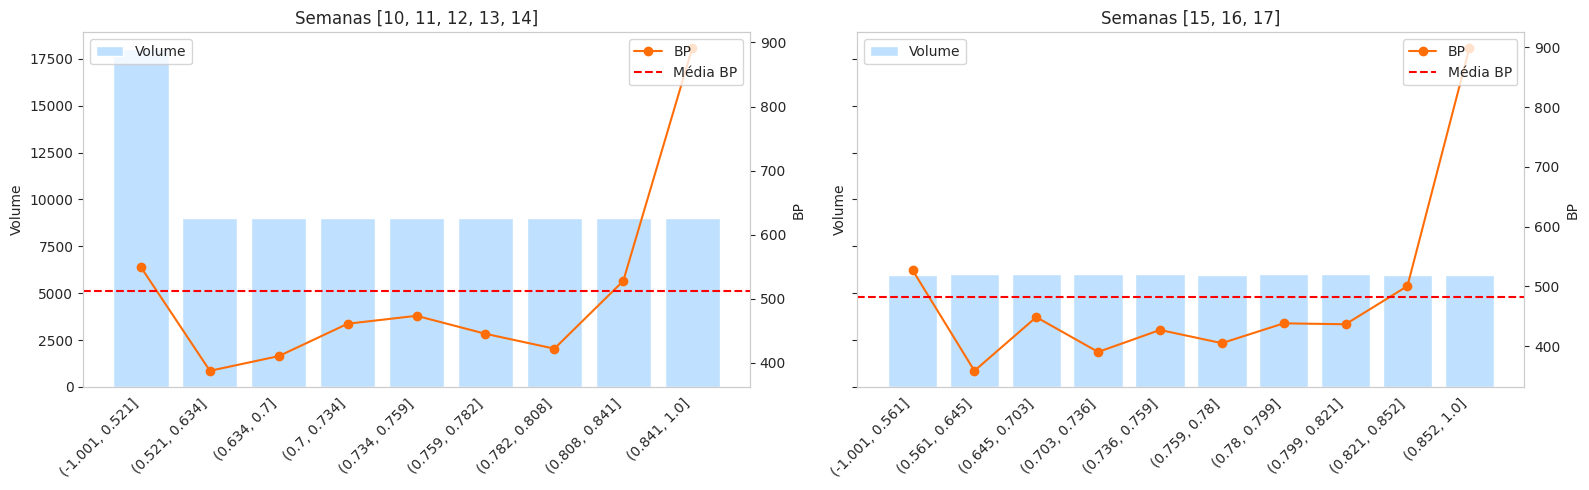

In [37]:
check_bad_var_compare(df, var='b_filled', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [38]:
df['b_filled_pos'] = df['b'].fillna(1.1)

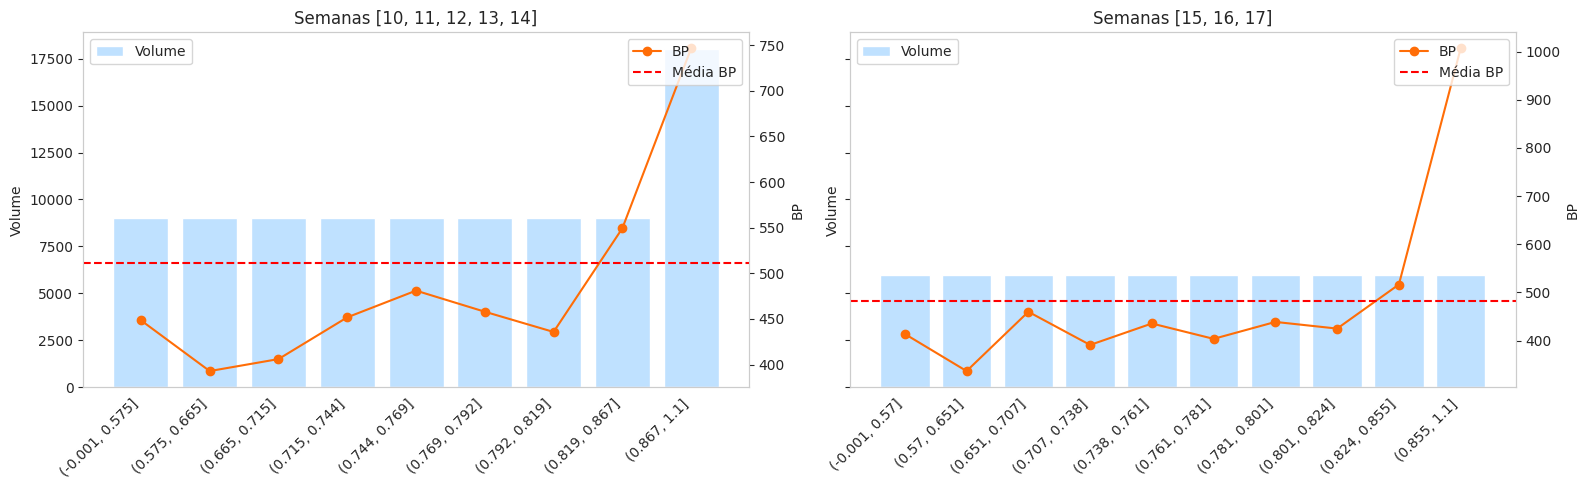

In [39]:
check_bad_var_compare(df, var='b_filled_pos', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

Analisando diferença entre discrminação da fraude dos casos nulos da variável 'b' para ver se ela se mantém estável

In [40]:
print('Discriminação da fraude de nulos no treino:',df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['b'].isna())].shape[0]/df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['b'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no treino: 5.910222436360716 %


In [41]:
print('Discriminação da fraude de nulos no teste:',df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['b'].isna())].shape[0]/df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['b'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no teste: 17.51412429378531 %


In [42]:
print('Discriminação da fraude de nulos no treino sem a semana com outliers:',df[(df['week'].isin([10, 12, 13, 14]))&(df['fraude'] == 1)&(df['b'].isna())].shape[0]/df[(df['week'].isin([10, 12, 13, 14]))&(df['b'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no treino sem a semana com outliers: 19.857142857142858 %


**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude em suas faixas de score
* Capacidade de discriminar a fraude maior nas maiores faixas de score
* A variável tem nulos
* Nulos demonstram comportamento discriminatório forte para a fraude
* Semana 11 contém outliers em relação a quantidade de nulos


---


**Comentários**
* Poderia ser esplorada a ideia de binarizar à partir de certa faixa de score também
* Como os nulos tem uma taxa de discriminação alta, pode ser explorado utilizar preenchimento com outlier positivo, facilitando um corte que explore valor alto da variavel + ser nula
* Para utilizar nulos como informaçõa seria interessante tratar a semana com outliers dessa variável, talvez inputando somente nela a mediana para não causar viés no treino



#### Analisando a variável c

##### Analise inicial

In [43]:
df.c.head(5).reset_index().T

0       1          2        3        4
index      0.00     1.0       2.00      3.0     4.00
c      94436.24  9258.5  242549.09  18923.9  5728.68

In [44]:
df.c.describe().reset_index().T

0              1              2     3         4          5  \
index     count           mean            std   min       25%        50%   
c      137016.0  260445.107044  846436.141626  0.16  9679.915  43711.655   

                 6            7  
index          75%          max  
c      145443.6275  13878743.71

Aparenta ser numérica continua

##### Análise de nulos

In [45]:
df.c.isna().sum()

12984

In [46]:
(df.c.isna().sum()/df.c.isna().count())*100

8.656

In [47]:
print('Train:',(df[df['OOT']=='train'].c.isna().sum()/df[df['OOT']=='train'].c.isna().count())*100)
print('Test:',(df[df['OOT']=='test'].c.isna().sum()/df[df['OOT']=='test'].c.isna().count())*100)

Train: 13.826987775224008
Test: 0.8859302267380749


In [48]:
missing_stats = df.groupby('week').agg(
    total_count=('c', 'size'),
    missing_count=('c', lambda x: x.isnull().sum())
).reset_index()

In [49]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

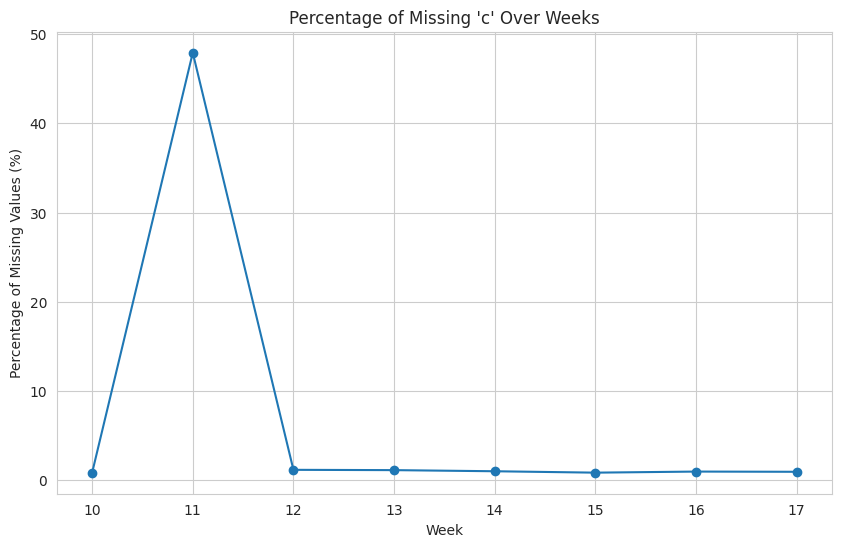

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'c' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

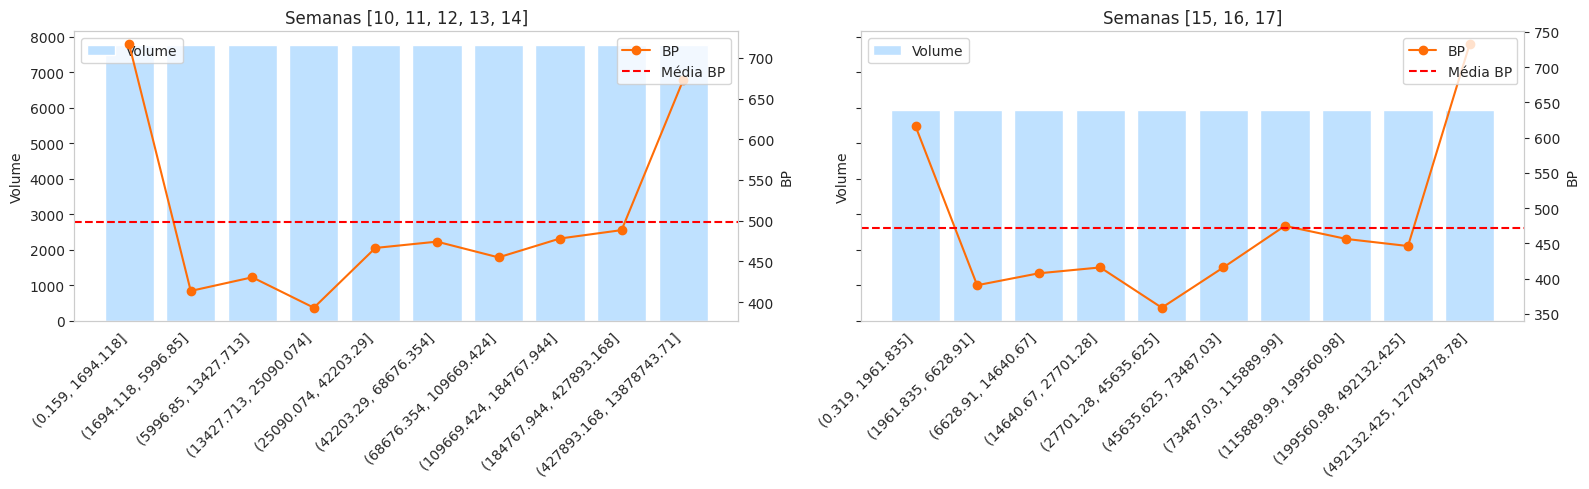

In [51]:
check_bad_var_compare(df, var='c', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

Analisando diferença entre discrminação da fraude dos casos nulos da variável 'c' para ver se ela se mantém estável

In [52]:
print('Discriminação da fraude de nulos no treino:',df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['c'].isna())].shape[0]/df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['c'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no treino: 5.910222436360716 %


In [53]:
print('Discriminação da fraude de nulos no teste:',df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['c'].isna())].shape[0]/df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['c'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no teste: 17.51412429378531 %


In [54]:
print('Discriminação da fraude de nulos no treino sem a semana com outliers:',df[(df['week'].isin([10, 12, 13, 14]))&(df['fraude'] == 1)&(df['c'].isna())].shape[0]/df[(df['week'].isin([10, 12, 13, 14]))&(df['c'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no treino sem a semana com outliers: 19.857142857142858 %


**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude em suas faixas de score
* Capacidade de discriminar a fraude maior nas menores faixas de score e no ante-penúltimo bin
* A variável tem nulos
* Nulos demonstram comportamento discriminatório forte para a fraude
* Semana 11 contém outliers em relação a quantidade de nulos


---


**Comentários**
* Poderia ser esplorada a ideia de binarizar à partir de certa faixa de score também
* Como os nulos tem uma taxa de discriminação alta, pode ser explorado utilizar preenchimento com outlier positivo, facilitando um corte que explore valor alto da variavel + ser nula
* Para utilizar nulos como informaçõa seria interessante tratar a semana com outliers dessa variável, talvez inputando somente nela a mediana para não causar viés no treino



#### Analisando a variável d

##### Analise inicial

In [55]:
df.d.head(5).reset_index().T

0    1    2     3     4
index   0.0  1.0  2.0   3.0   4.0
d      20.0  1.0  3.0  50.0  15.0

In [56]:
df.d.describe().reset_index().T

0          1          2    3    4     5     6     7
index     count       mean        std  min  25%   50%   75%   max
d      149635.0  21.677669  20.062146  0.0  2.0  14.0  50.0  50.0

Aparenta ser numérica mas nao continua

##### Análise de nulos

In [57]:
df.d.isna().sum()

365

In [58]:
 (df.d.isna().sum()/df.d.isna().count())*100

0.24333333333333335

In [59]:
print('Train:',(df[df['OOT']=='train'].d.isna().sum()/df[df['OOT']=='train'].d.isna().count())*100,'%')
print('Test:',(df[df['OOT']=='test'].d.isna().sum()/df[df['OOT']=='test'].d.isna().count())*100,'%')

Train: 0.299790146897172 %
Test: 0.15849975807931663 %


In [60]:
missing_stats = df.groupby('week').agg(
    total_count=('d', 'size'),
    missing_count=('d', lambda x: x.isnull().sum())
).reset_index()

In [61]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

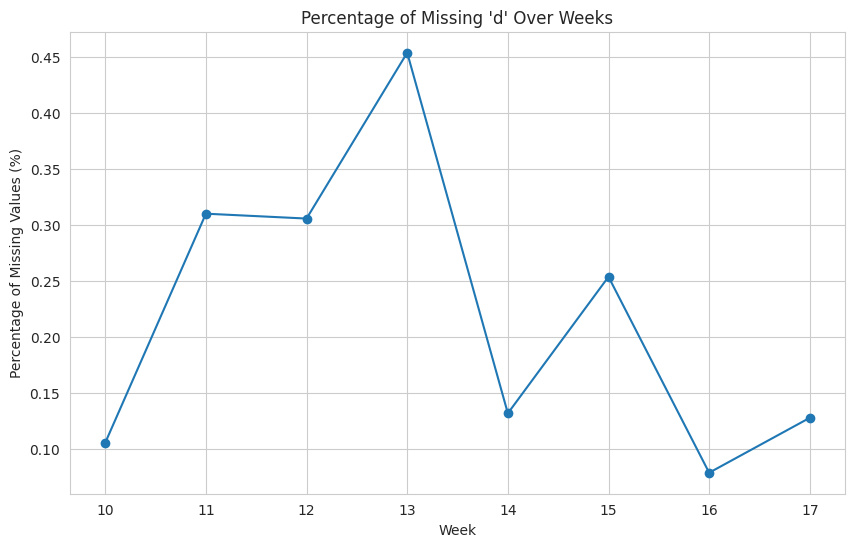

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'd' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

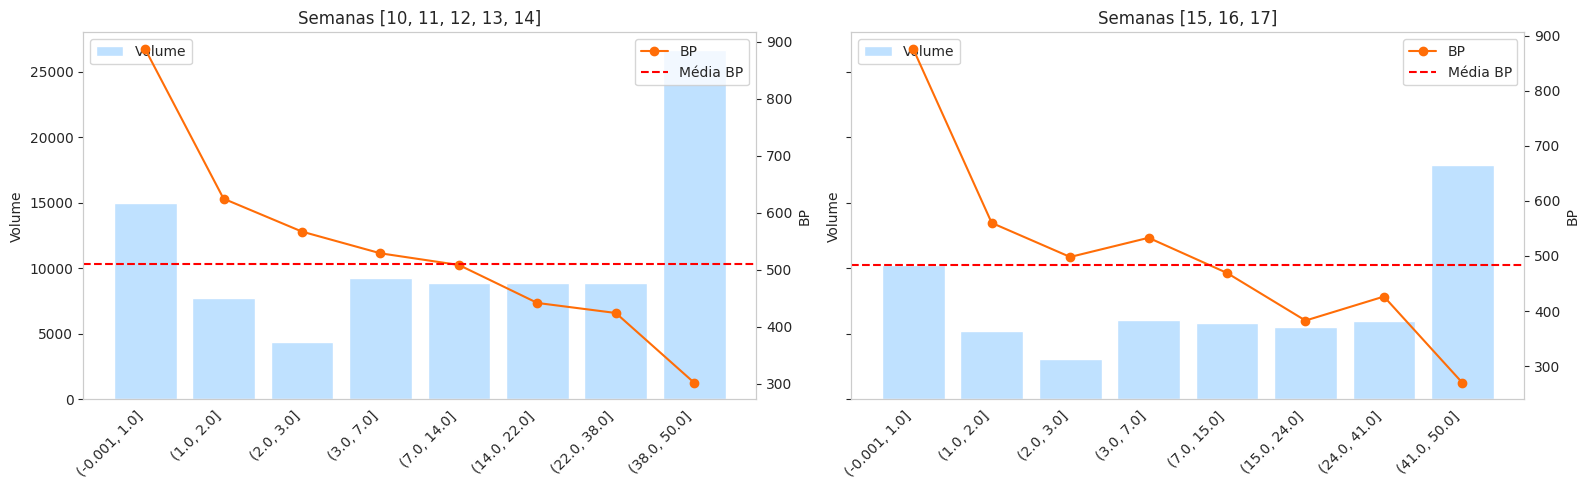

In [63]:
check_bad_var_compare(df, var='d', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [64]:
df.d.value_counts(normalize=True).cumsum().reset_index().T

0         1         2         3         4          5   \
d           50.000000  1.000000  2.000000  3.000000  4.000000  20.000000   
proportion   0.257941  0.421319  0.507923  0.557677  0.592642   0.619675   

                  6         7         8         9         10         11  \
d           5.000000  6.000000  7.000000  8.000000  9.000000  10.000000   
proportion  0.646106  0.668253  0.687119  0.703525  0.718642   0.732289   

                   12         13         14         15         16         17  \
d           12.000000  11.000000  13.000000  14.000000  15.000000  16.000000   
proportion   0.745454   0.758292   0.770488   0.781796   0.792655   0.803395   

                   18         19         20         21         22         23  \
d           17.000000  19.000000  18.000000  21.000000  22.000000  24.000000   
proportion   0.813399   0.823297   0.833154   0.841314   0.849313   0.857246   

                   24         25         26         27         28         29  \
d           23.000000  25.000000  26.000000  28.000000  29.000000  27.000000   
proportion   0.864905   0.872002   0.878972   0.885822   0.892605   0.899268   

                   30         31         32         33         34         35  \
d           30.000000  31.000000  32.000000  33.000000  34.000000  35.000000   
proportion   0.905483   0.911471   0.917232   0.922759   0.928185   0.933565   

                  36         37         38         39         40         41  \
d           0.000000  37.000000  36.000000  38.000000  40.000000  39.000000   
proportion  0.938818   0.944064   0.949156   0.954008   0.958666   0.963317   

                   42         43         44         45        46         47  \
d           43.000000  42.000000  41.000000  44.000000  48.00000  45.000000   
proportion   0.967742   0.972159   0.976516   0.980833   0.98475   0.988652   

                   48         49    50  
d           46.000000  49.000000  47.0  
proportion   0.992535   0.996311   1.0

In [65]:
df.groupby("d")["fraude"].mean().reset_index(name="bad_rate").sort_values('bad_rate').T

39         50         49        45        46         47  \
d         39.000000  50.000000  49.000000  45.00000  46.00000  47.000000   
bad_rate   0.022989   0.028111   0.028319   0.02911   0.02926   0.030797   

                44         40         38         29         20         26  \
d         44.00000  40.000000  38.000000  29.000000  20.000000  26.000000   
bad_rate   0.03096   0.032999   0.034435   0.035468   0.035847   0.036433   

                 36         27         33         22         42         24  \
d         36.000000  27.000000  33.000000  22.000000  42.000000  24.000000   
bad_rate   0.036745   0.037111   0.037485   0.037594   0.037821   0.037911   

                 35         28        37         11         17         48  \
d         35.000000  28.000000  37.00000  11.000000  17.000000  48.000000   
bad_rate   0.038509   0.039024   0.03949   0.040604   0.040748   0.040956   

                 23         15         25         30         13        19  \
d         23.000000  15.000000  25.000000  30.000000  13.000000  19.00000   
bad_rate   0.042757   0.045538   0.046139   0.046237   0.046575   0.04659   

                 21         43       9          12         32        6   \
d         21.000000  43.000000  9.00000  12.000000  32.000000  6.000000   
bad_rate   0.046683   0.046828  0.04863   0.048731   0.049884  0.050091   

                 10        5          41        4          31         16  \
d         10.000000  5.000000  41.000000  4.000000  31.000000  16.000000   
bad_rate   0.050441  0.051833   0.052147  0.052179   0.052455   0.052894   

                8          34        3          18         14        7   \
d         8.000000  34.000000  3.000000  18.000000  14.000000  7.000000   
bad_rate  0.052953   0.052956  0.053862   0.054237   0.056147  0.059865   

                2        1         0   
d         2.000000  1.00000  0.000000  
bad_rate  0.059881  0.08455  0.203562

Analisando diferença entre discrminação da fraude dos casos nulos da variável 'b' para ver se ela se mantém estável

In [66]:
print('Discriminação da fraude de nulos no treino:',df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['d'].isna())].shape[0]/df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['d'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no treino: 9.25925925925926 %


In [67]:
print('Discriminação da fraude de nulos no teste:',df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['d'].isna())].shape[0]/df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['d'].isna())].shape[0]*100,'%')

Discriminação da fraude de nulos no teste: 4.2105263157894735 %


**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude em suas faixas de score
* Capacidade de discriminar a fraude maior nas menores faixas de score e vai decaindo na escala da variavel
* A variável tem nulos
* Nulos demonstram leve comportamento discriminatório para a fraude



---


**Comentários**
* Como os nulos tem uma discriminação não muito diferente entre o treino e teste e sem viés temporal, pode ser abordada estratégia de preencher com outliers.

#### Analisando a variável e

##### Analise inicial

In [68]:
df.e.head(5).reset_index().T

0    1    2         3    4
index  0.000000  1.0  2.0  3.000000  4.0
e      0.444828  0.0  0.0  0.482385  0.0

In [69]:
df.e.describe().reset_index().T

0         1         2    3    4         5         6           7
index     count      mean       std  min  25%       50%       75%         max
e      150000.0  0.220641  2.434995  0.0  0.0  0.104875  0.282938  833.333333

Aparenta ser numérica continua

##### Análise de nulos

In [70]:
df.e.isna().sum()

0

In [71]:
(df.e==0).sum()

65055

In [72]:
 ((df.e==0).sum()/(df.e==0).count())*100

43.37

In [73]:
print('Train:',((df[df['OOT']=='train'].e==0).sum()/(df[df['OOT']=='train'].e==0).count())*100,'%')
print('Test:',((df[df['OOT']=='test'].e==0).sum()/(df[df['OOT']=='test'].e==0).count())*100,'%')

Train: 44.98628737661415 %
Test: 40.94132172114053 %


o 0,0 aparenta ser um indicativo de nulo

In [74]:
missing_stats = df.groupby('week').agg(
    total_count=('e', 'size'),
    missing_count=('e', lambda x: (x==0).sum())
).reset_index()

In [75]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

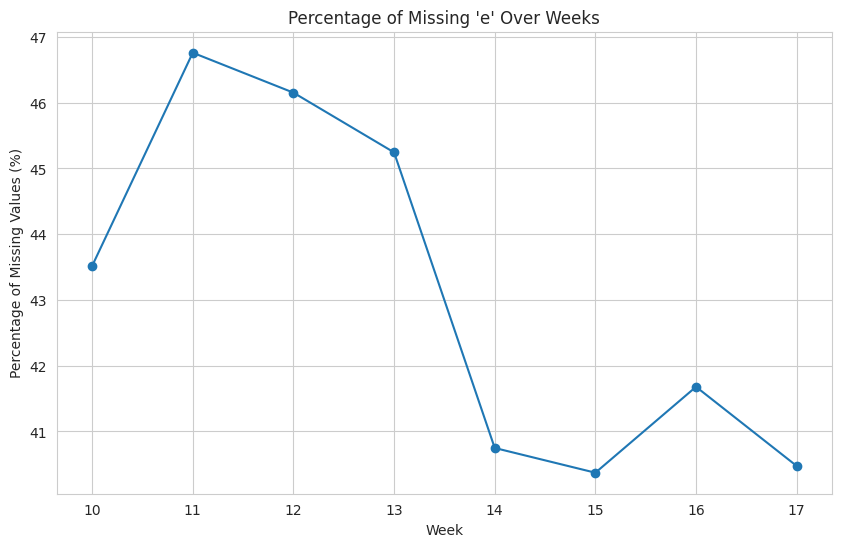

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'e' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

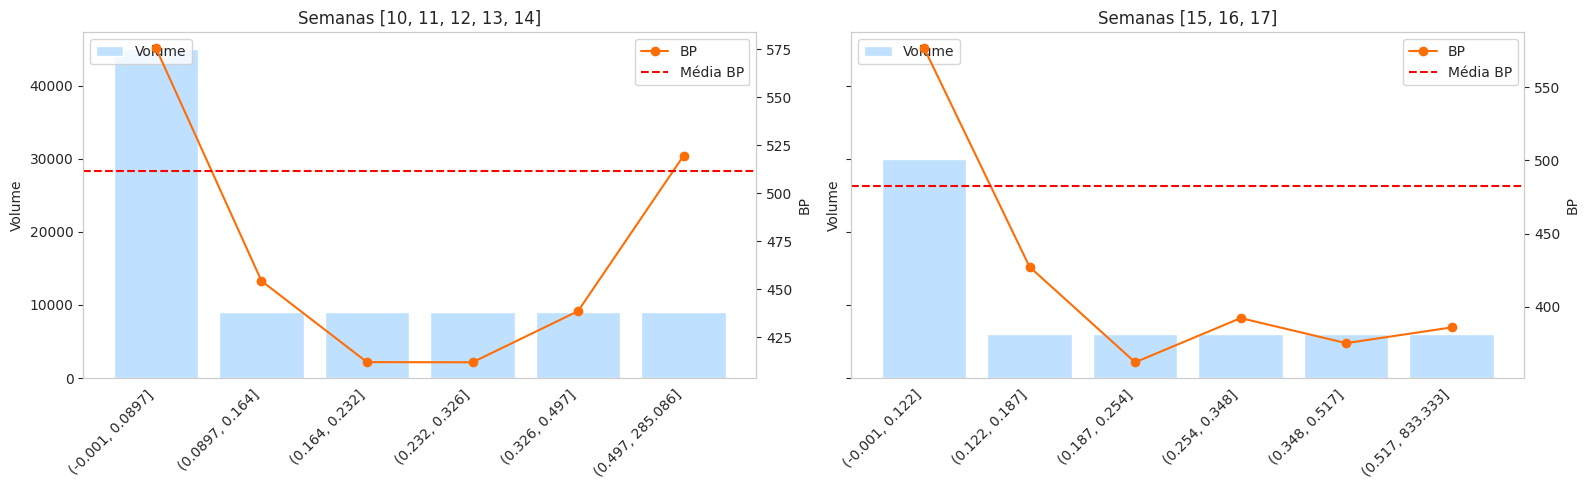

In [77]:
check_bad_var_compare(df, var='e', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

Analisando diferença entre discrminação da fraude dos casos nulos da variável 'b' para ver se ela se mantém estável

In [78]:
print('Discriminação da fraude de nulos no treino:',df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['e']==0)].shape[0]/df[(df['week'].isin([10, 11, 12, 13, 14]))&(df['e']==0)].shape[0]*100,'%')

Discriminação da fraude de nulos no treino: 5.568170599269425 %


In [79]:
print('Discriminação da fraude de nulos no teste:',df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['fraude'] == 1)&(df['e']==0)].shape[0]/df[~(df['week'].isin([10, 11, 12, 13, 14]))&(df['e']==0)].shape[0]*100,'%')

Discriminação da fraude de nulos no teste: 5.656302212804108 %


**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude em suas faixas de score
* Capacidade de discriminar a fraude maior nas menores faixas de score e vai decaindo na escala da variavel
* A variável tem nulos
* Nulos demonstram leve comportamento discriminatório para a fraude



---


**Comentários**
* Como os nulos tem uma discriminação não muito diferente entre o treino e teste e sem viés temporal, pode ser abordada estratégia de preencher com outliers.

#### Analisando a variável f

##### Analise inicial

In [80]:
df.f.head(5).reset_index().T

0     1     2     3    4
index  0.0   1.0   2.0   3.0  4.0
f      1.0  33.0  19.0  18.0  1.0

In [81]:
df.f.describe().reset_index().T

0          1           2    3    4    5     6         7
index     count       mean         std  min  25%  50%   75%       max
f      149989.0  51.169352  709.472904 -5.0  1.0  8.0  33.0  145274.0

Aparenta ser numérica

##### Análise de nulos

In [82]:
df.f.isna().sum()

11

In [83]:
(df.f==0).sum()

25390

In [84]:
 ((df.f==0).sum()/(df.f==0).count())*100

16.92666666666667

In [85]:
print('Train:',((df[df['OOT']=='train'].f==0).sum()/(df[df['OOT']=='train'].f==0).count())*100,'%')
print('Test:',((df[df['OOT']=='test'].f==0).sum()/(df[df['OOT']=='test'].f==0).count())*100,'%')

Train: 16.588388128310182 %
Test: 17.434973388724828 %


o 0,0 aparenta ser um indicativo de nulo

In [86]:
missing_stats = df.groupby('week').agg(
    total_count=('f', 'size'),
    missing_count=('f', lambda x: x.isna().sum())
).reset_index()

In [87]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

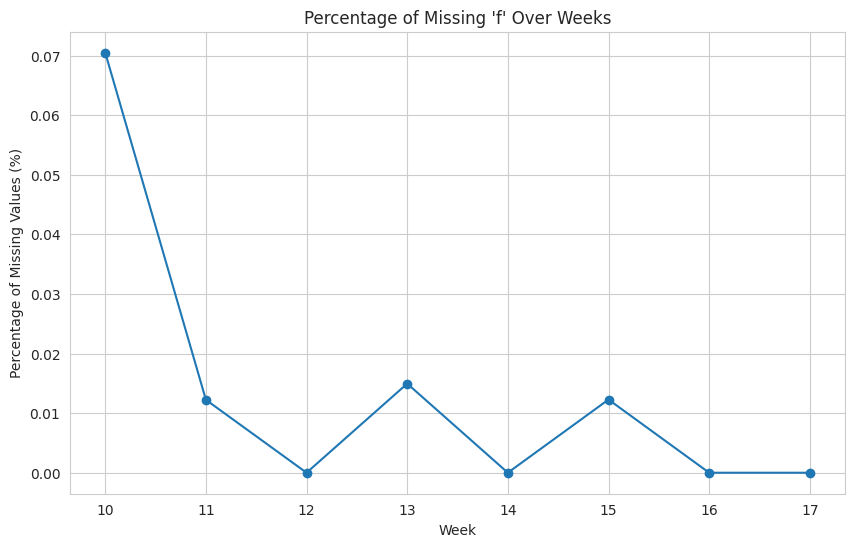

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'f' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

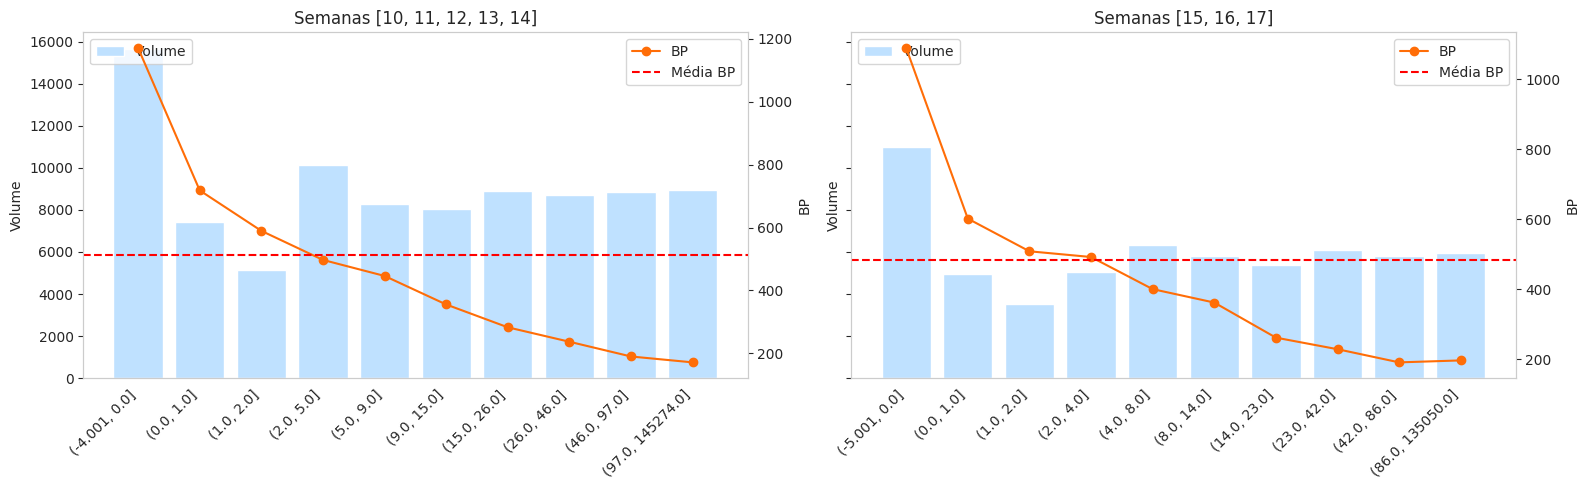

In [89]:
check_bad_var_compare(df, var='f', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

<Axes: xlabel='f', ylabel='Count'>

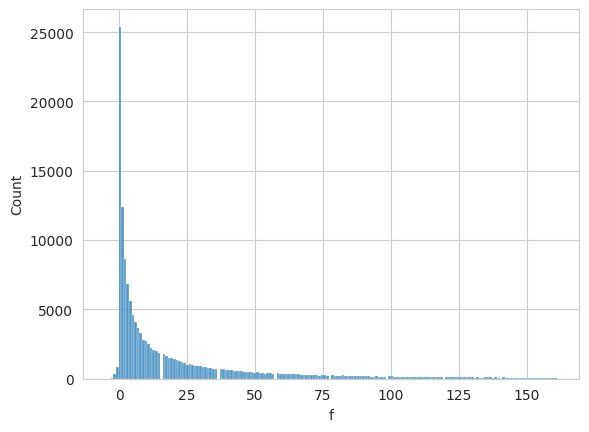

In [90]:
sns.histplot(df[df['f'] < df.f.quantile(0.95)].f)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude em suas faixas de score
* Capacidade de discriminar a fraude maior nas menores faixas de score e vai decaindo na escala da variavel
* A variável tem muito pouco nulos



---


**Comentários**
* Preencher nulos como outliers (porém não vai afetar muito ja que são muito poucos)

#### Analisando a variável g

##### Analise inicial

In [91]:
df.g.head(5).reset_index().T

0   1   2   3   4
index   0   1   2   3   4
g      BR  BR  AR  BR  BR

In [92]:
df.g.value_counts(normalize=True).cumsum().reset_index().T

0        1         2         3         4         5   \
g                BR       AR        UY        US        SE        MX   
proportion  0.74515  0.95852  0.978325  0.993498  0.995888  0.997463   

                  6         7         8         9         10        11  \
g                 RU        ES        CO        GB        FR        IT   
proportion  0.997951  0.998411  0.998838  0.999126  0.999246  0.999339   

                  12        13        14        15        16        17  \
g                 PT        DE        CL        PE        EC        PY   
proportion  0.999426  0.999486  0.999546  0.999579  0.999606  0.999633   

                  18        19        20        21        22        23  \
g                 AU        PA        CA        UA        BE        CN   
proportion  0.999653  0.999673  0.999693  0.999713  0.999733  0.999753   

                  24        25        26       27        28        29  \
g                 CH        NZ        PR       NL        BO        CR   
proportion  0.999773  0.999793  0.999806  0.99982  0.999833  0.999846   

                 30        31       32        33        34      35        36  \
g                AE        LB       FI        TW        NO      EG        IL   
proportion  0.99986  0.999873  0.99988  0.999887  0.999893  0.9999  0.999907   

                  37       38        39        40       41        42  \
g                 PH       JP        GH        NI       DO        BS   
proportion  0.999913  0.99992  0.999927  0.999933  0.99994  0.999947   

                  43       44        45        46       47        48  \
g                 TR       IN        GR        HN       KR        GE   
proportion  0.999953  0.99996  0.999967  0.999973  0.99998  0.999987   

                  49   50  
g                 AD   ZA  
proportion  0.999993  1.0

Categórica e indica o país da transação

##### Análise de nulos

In [93]:
df.g.isna().sum()

194

In [94]:
print('Train:',((df[df['OOT']=='train'].g.isna()).sum()/(df[df['OOT']=='train'].g.isna()).count())*100,'%')
print('Test:',((df[df['OOT']=='test'].g.isna()).sum()/(df[df['OOT']=='test'].g.isna()).count())*100,'%')

Train: 0.06773036652121293 %
Test: 0.22189966131104327 %


poucos nulos

In [95]:
missing_stats = df.groupby('week').agg(
    total_count=('g', 'size'),
    missing_count=('g', lambda x: x.isna().sum())
).reset_index()

In [96]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

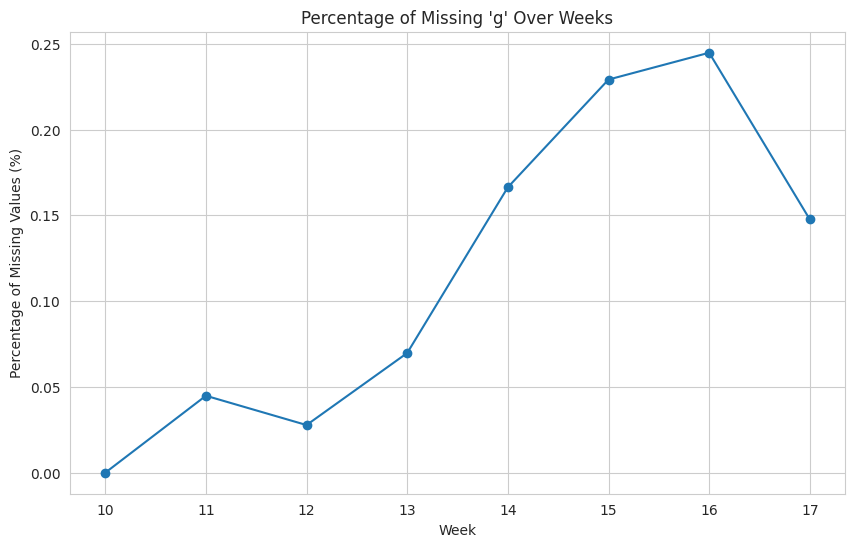

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'g' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

In [98]:
df['g_agrup_simples'] = df['g'].apply(lambda x: x if x in ['BR','AR'] else 'others')

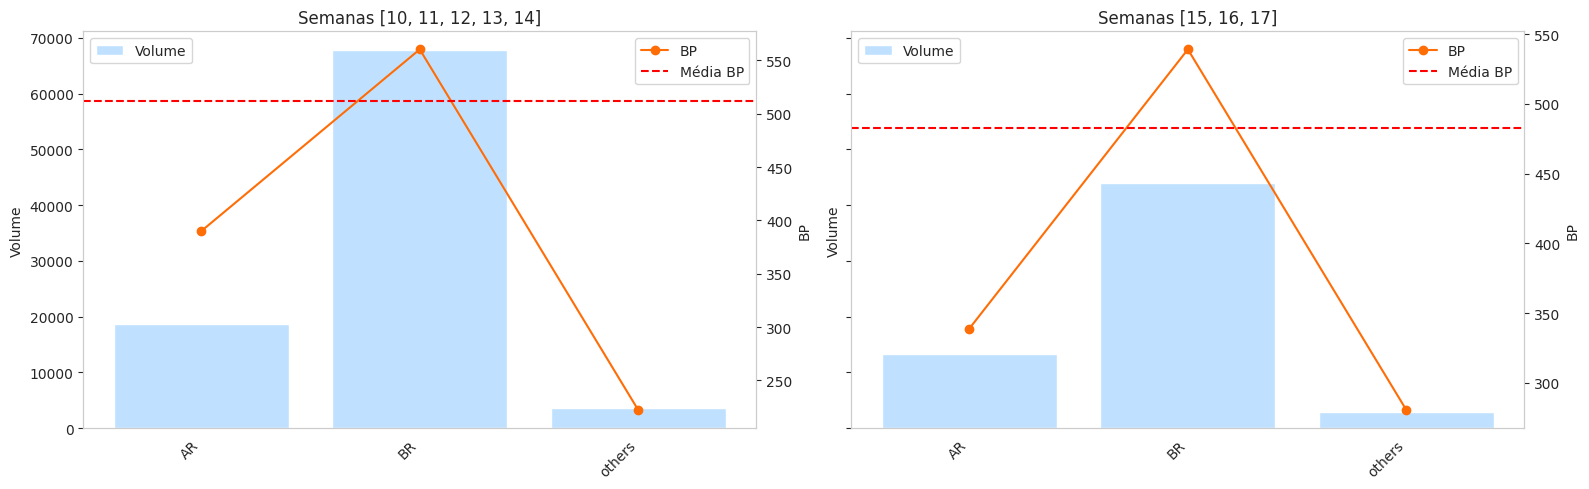

In [99]:
check_bad_var_compare(df, var='g_agrup_simples', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

In [100]:
df['g_agrup_simples_num'] = df['g_agrup_simples'].map({'BR':2,'AR':1, 'others':0})

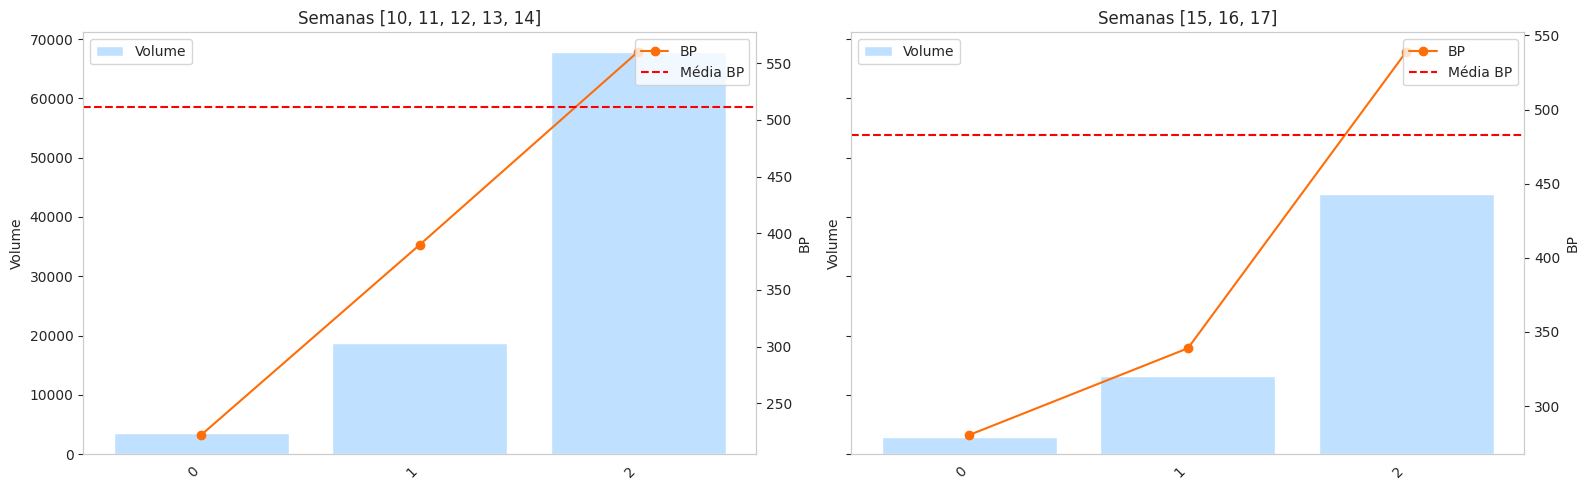

In [101]:
check_bad_var_compare(df, var='g_agrup_simples_num', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

In [102]:
continent_map = {
    "BR": "BR",
    "AR": "AR",
    "UY": "South America",
    "US": "North America",
    "SE": "Europe",
    "MX": "North America",
    "RU": "Europe",    # Rússia é transcontinental, mas costuma entrar como Europa
    "ES": "Europe",
    "CO": "South America",
    "GB": "Europe",
    "FR": "Europe",
    "IT": "Europe",
    "PT": "Europe",
    "DE": "Europe",
    "CL": "South America",
    "PE": "South America",
    "EC": "South America",
    "PY": "South America",
    "AU": "Oceania",
    "PA": "North America",
    "CA": "North America",
    "UA": "Europe",
    "BE": "Europe",
    "CN": "Asia",
    "CH": "Europe",
    "NZ": "Oceania",
    "PR": "North America",
    "NL": "Europe",
    "BO": "South America",
    "CR": "North America",
    "AE": "Asia",
    "LB": "Asia",
    "FI": "Europe",
    "TW": "Asia",
    "NO": "Europe",
    "EG": "Africa",
    "IL": "Asia",
    "PH": "Asia",
    "JP": "Asia",
    "GH": "Africa",
    "NI": "North America",
    "DO": "North America",
    "BS": "North America",
    "TR": "Europe",   # Turquia também é transcontinental
    "IN": "Asia",
    "GR": "Europe",
    "HN": "North America",
    "KR": "Asia",
    "GE": "Europe",   # Geórgia tem discussão similar
    "AD": "Europe",
    "ZA": "Africa"
}

In [103]:
df['g_agrup_continente'] = df['g'].apply(lambda x: continent_map.get(x, 'others'))

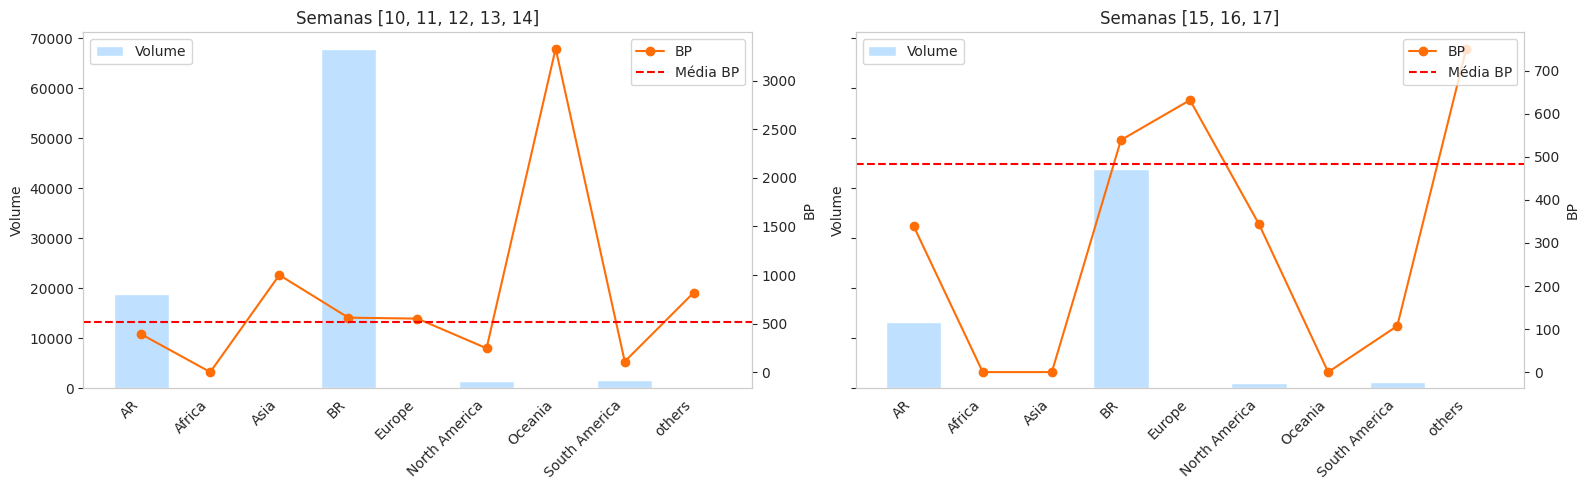

In [104]:
check_bad_var_compare(df, var='g_agrup_continente', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude quando dividido em AR, BR e others
* grande parte do volume esta em AR e BR
* BR tem maior bad-rate
* volume de nulos bem baixo
* baixa volumetria dos diferentes continentes



---


**Comentários**
* Preencher nulos como others
* possibilidade de binarizar em AR, BR e others
* pode-se utilizar também uma abordagem the bad-rate encoding (ordenar pela ordem do percentual de fraudes por categoria) para facilitar a busca de um corte no modelo que agrupe AR e BR por exemplo
* dificil usar uma abordagem de agrupar por continente por suas volumetrias muito baixas o que também causa uma instabilidade do comportamento discriminatório ao longo do tempo

#### Analisando a variável h

##### Analise inicial

In [105]:
df.h.head(5).reset_index().T

0  1   2   3  4
index  0  1   2   3  4
h      5  0  23  23  2

In [106]:
df.h.describe().reset_index().T

0          1          2    3    4    5     6     7
index     count       mean        std  min  25%  50%   75%   max
h      150000.0  14.193513  14.161216  0.0  3.0  9.0  21.0  58.0

numérica

##### Análise de nulos

In [107]:
df.h.isna().sum()

0

In [108]:
print('Train:',((df[df['OOT']=='train'].h==0).sum()/(df[df['OOT']=='train'].h == 0).count())*100,'%')
print('Test:',((df[df['OOT']=='test'].h == 0).sum()/(df[df['OOT']=='test'].h == 0).count())*100,'%')

Train: 8.878229683665879 %
Test: 8.08181924353905 %


o 0,0 pode ser um indicativo de nulo

In [109]:
missing_stats = df.groupby('week').agg(
    total_count=('h', 'size'),
    missing_count=('h', lambda x: (x==0).sum())
).reset_index()

In [110]:
missing_stats['missing_pct'] = (missing_stats['missing_count'] / missing_stats['total_count']) * 100

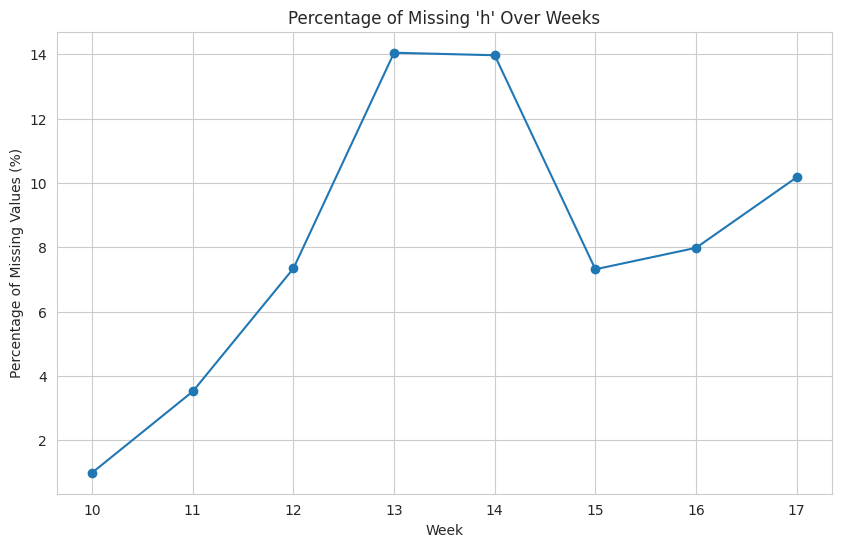

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(missing_stats['week'], missing_stats['missing_pct'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Percentage of Missing Values (%)')
plt.title("Percentage of Missing 'h' Over Weeks")
plt.grid(True)
plt.show()

##### Análise de estabilidade X BP

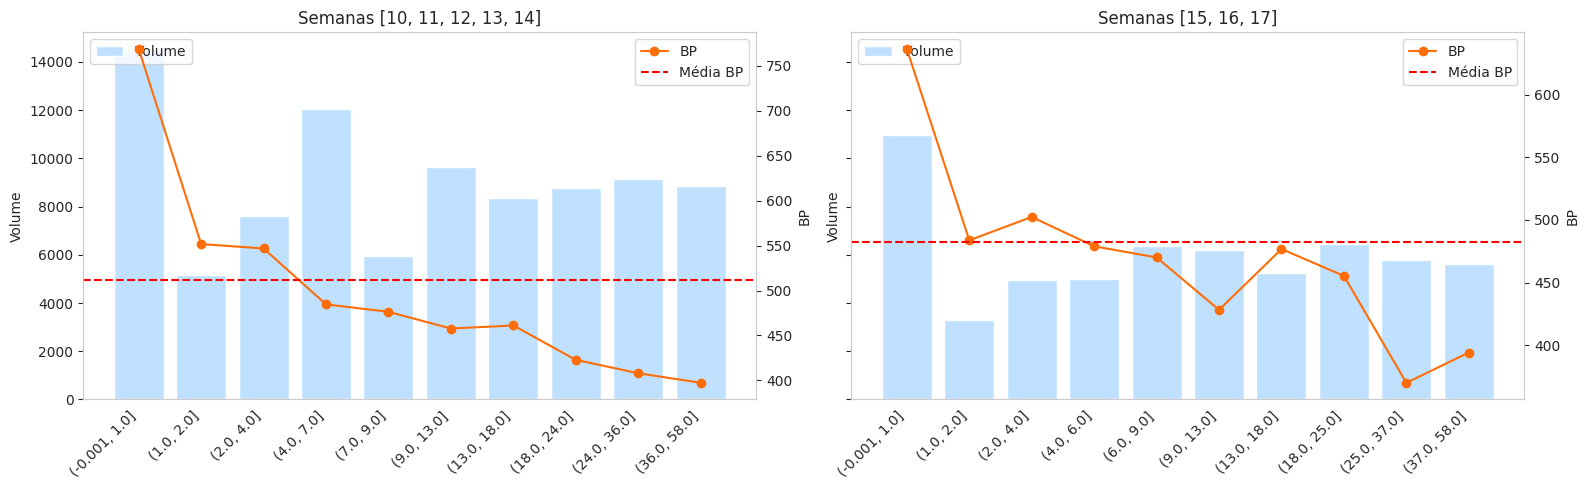

In [112]:
check_bad_var_compare(df, var='h', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

In [113]:
def plot_feature_distribution(df, var, week_filter1, week_filter2):
    """
    Plots the distribution of a feature for two different week filters.

    Parameters:
        df (DataFrame): Your dataset.
        var (str): The feature column.
        week_filter1 (list): Weeks for the first subset.
        week_filter2 (list): Weeks for the second subset.
    """
    df1 = df[df['week'].isin(week_filter1)]
    df2 = df[df['week'].isin(week_filter2)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    sns.histplot(df1[var], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution for weeks {week_filter1}")

    sns.histplot(df2[var], kde=True, ax=axes[1], color="salmon")
    axes[1].set_title(f"Distribution for weeks {week_filter2}")

    plt.tight_layout()
    plt.show()


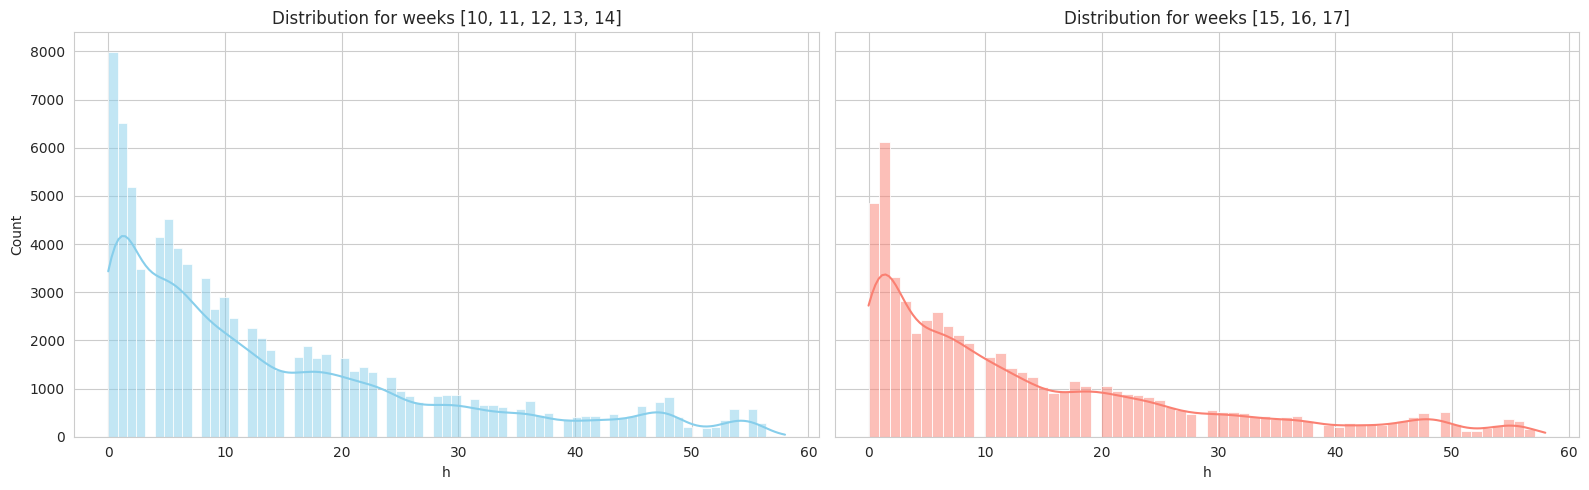

In [114]:
plot_feature_distribution(df, 'h',
                          week_filter1=[10, 11, 12, 13, 14],
                          week_filter2=[15, 16, 17],)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Discriminação de fraude segue os valores de forma decrescente (quanto menor o valor menor a concetração de fraudes)
* sem nulos
* mais zeros no treino que no teste


---


**Comentários**
* Zeros no treino aumentados proporcionalmente podem indicar algum problema de preenchimento da variável na época em questão

#### Analisando a variável i

##### Analise inicial

In [115]:
df.i.head(5).reset_index().T

0  \
index                                                  0   
i      Máquininha Corta Barba Cabelo Peito Perna Pelo...   

                                                       1  \
index                                                  1   
i      Avental Descartavel Manga Longa  - 50 Un. Tnt ...   

                                                       2  \
index                                                  2   
i      Bicicleta Mountain Fire Bird Rodado 29 Alumini...   

                                                       3  \
index                                                  3   
i      Caneta Delineador Carimbo Olho Gatinho Longo 2...   

                                              4  
index                                         4  
i      Resident Evil Operation Raccoon City Ps3

variável textual e indica produto comprado

##### Análise de nulos

In [116]:
df.i.isna().sum()

0

In [117]:
(df.i == '').sum()

0

In [118]:
(df.i.str.replace(' ','') == '').sum()

0

##### Análise de estabilidade X BP de padrões simples no texto

###### Análise tamanho da palavra

In [119]:
df['i_len'] = df.i.str.len()

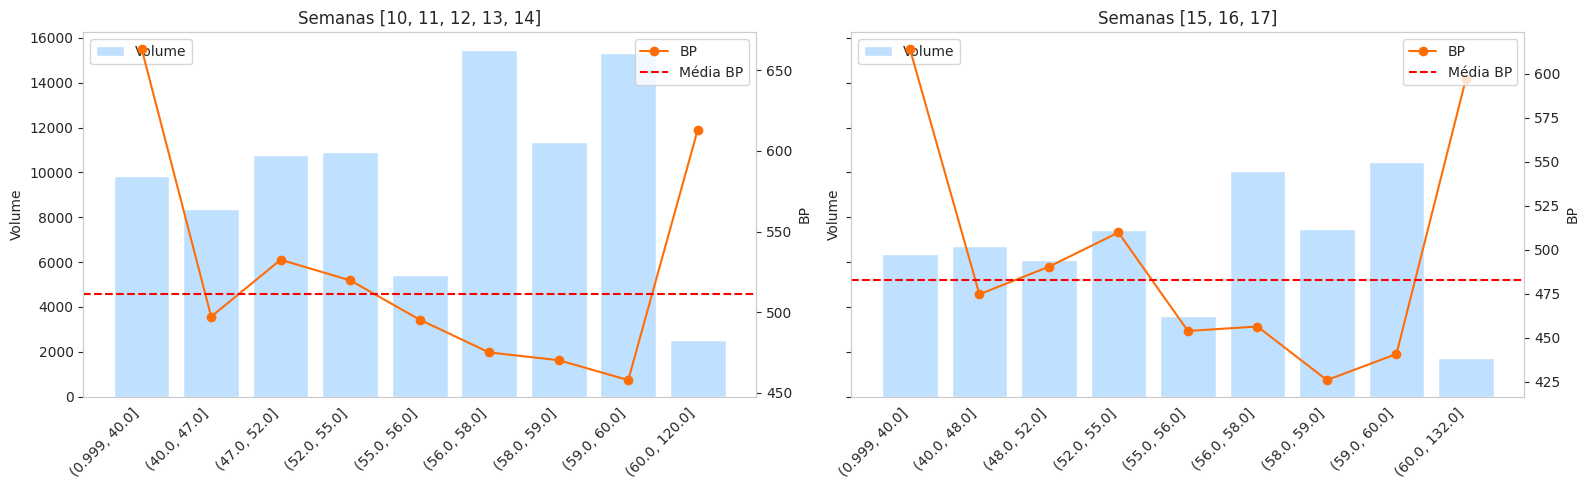

In [120]:
check_bad_var_compare(df, var='i_len', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Discriminação de fraude menores e maiores valores
* sem nulos
---
**Comentários**
* Possibilidade de usar variável como numérica

###### Análise caracteres especiais

In [121]:
import re

In [122]:
special_chars_re = re.compile(r'[^A-Za-z0-9\s]')
def count_special_chars(x):
    return len(special_chars_re.findall(x))

In [123]:
df['i_special_chars'] = df.i.apply(count_special_chars)

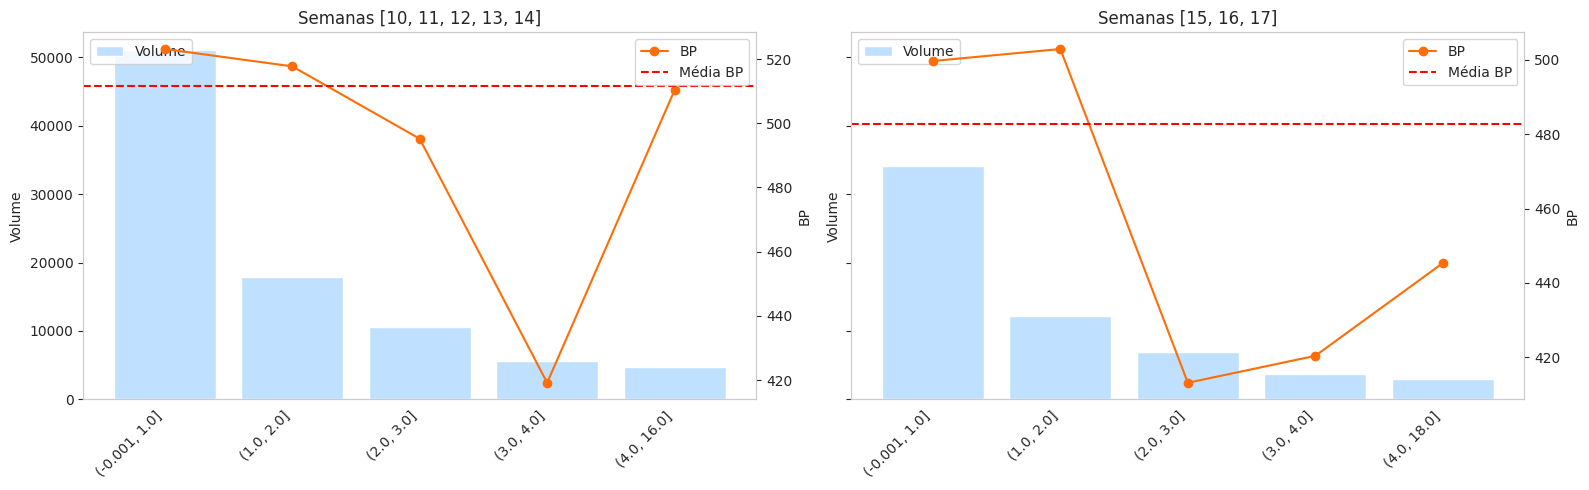

In [124]:
check_bad_var_compare(df, var='i_special_chars',
                      target='fraude',
                      tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [125]:
df['i_special_chars_agrup'] = df.i_special_chars.apply(lambda x :x if x in [0,1,2] else '>2')

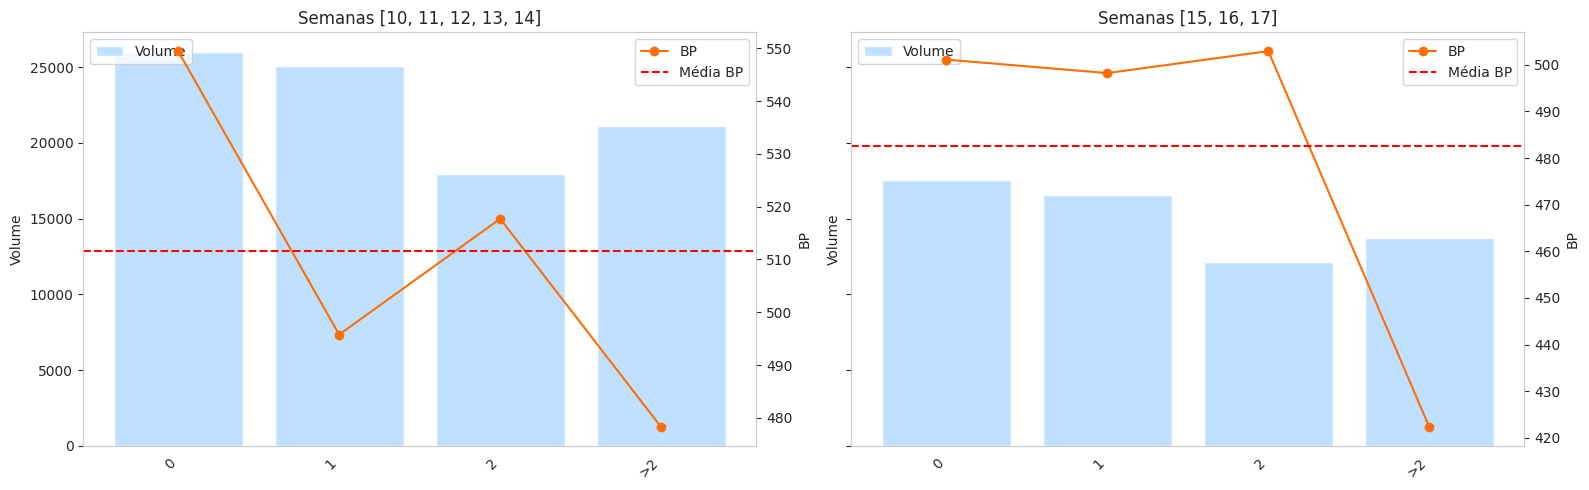

In [126]:
check_bad_var_compare(df, var='i_special_chars_agrup',
                      target='fraude',
                      tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [127]:
df['i_special_chars_agrup_num'] = df.i_special_chars_agrup.map({0:0, 1:1, 2:2, '>2':3}).astype(int)

faz ficar mais estavel o agrupamento

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Discriminação de fraude menor quando tem mais caracteres especiais
* sem nulos

---

**Comentários**
* Possibilidade de usar como numérica sendo o número 3 = >2 caracteres

###### Análise quantidade de números

In [128]:
def count_numbers(text):
    numbers = re.findall(r'\d+', text)  # encontra todos os números
    return len(numbers)

In [129]:
df['i_num_count'] = df.i.apply(count_numbers)

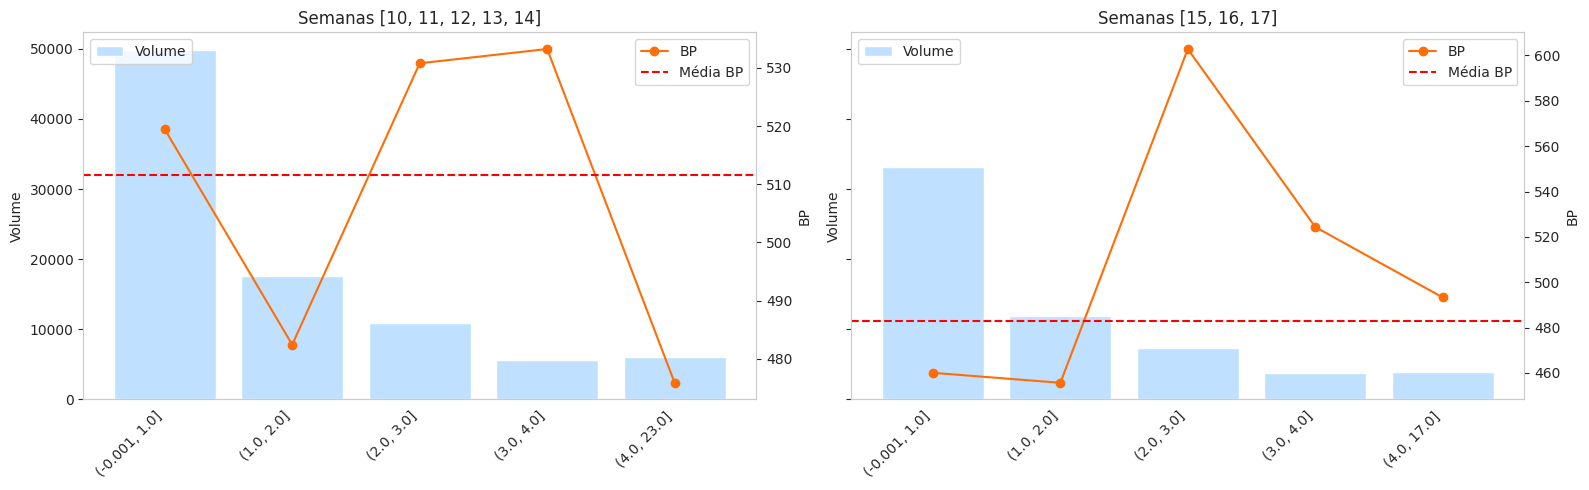

In [130]:
check_bad_var_compare(df, var='i_num_count', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

muito instável no OOT

In [131]:
df['i_num_count_agrup'] = df.i_num_count.apply(lambda x: x if x <=2 else '>2')

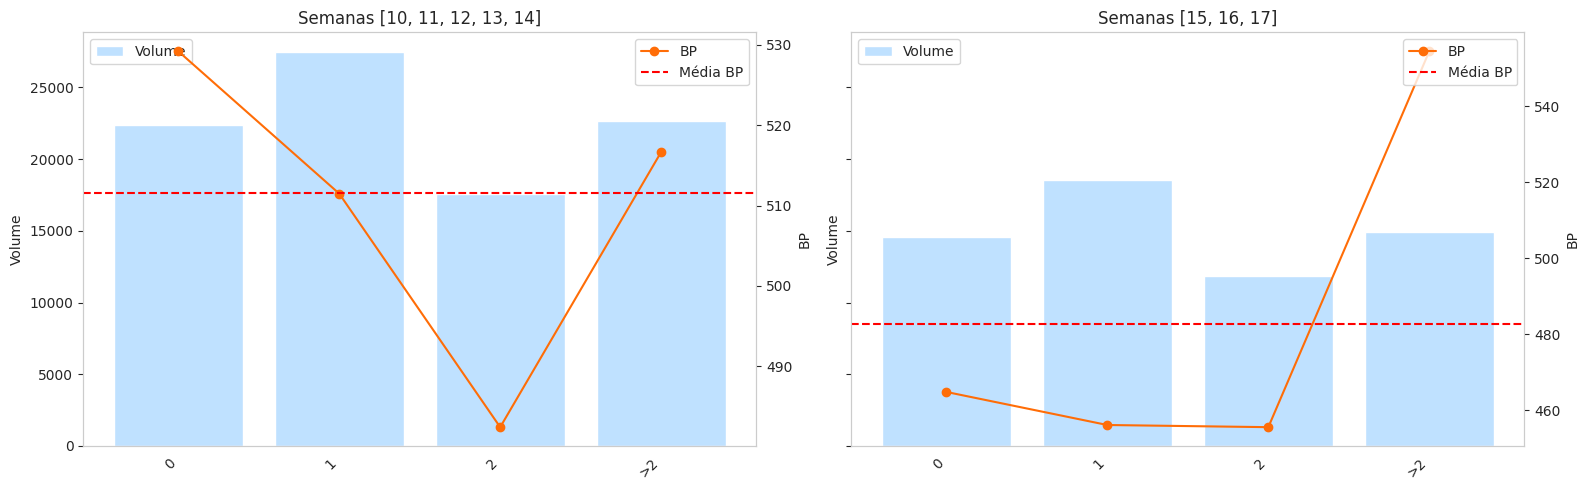

In [132]:
check_bad_var_compare(df, var='i_num_count_agrup', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

ainda instável no OOT

In [133]:
df['i_num_count_agrup'] = df.i_num_count.apply(lambda x: '<=2' if x <=2 else '>2')

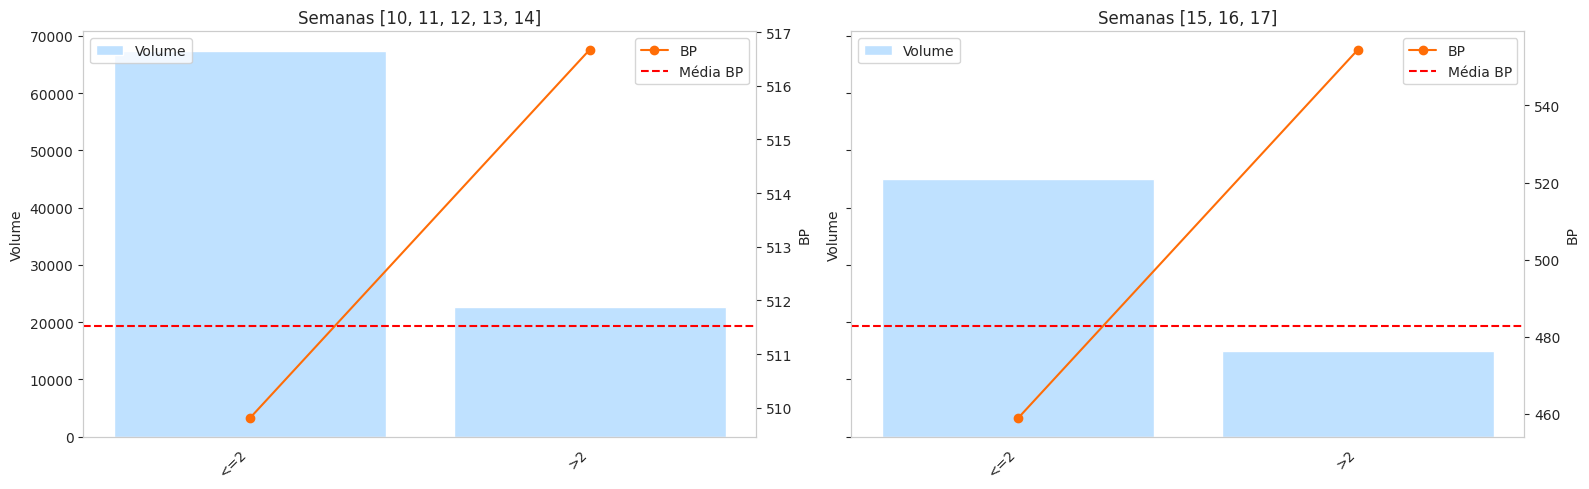

In [134]:
check_bad_var_compare(df, var='i_num_count_agrup', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

In [135]:
df['i_num_count_agrup_num'] = df.i_num_count_agrup.map({'<=2':0, '>2':1}).astype(int)

Melhorou

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude quando agrupada em <=2 e >2
* Discriminação de fraude maior quando >2
* sem nulos
---
**Comentários**
* Possibilidade de usar variável agrupada como binária

###### Análise quantidade de números soltos

In [136]:
def count_numbers_with_spaces(text):
    # This pattern matches a sequence of digits, optionally with spaces in between,
    # surrounded by word boundaries.
    pattern = r'\b\d+(?:\s\d+)*\b'
    numbers = re.findall(pattern, text)
    return len(numbers)

In [137]:
df['i_num_count_sep'] = df.i.apply(count_numbers_with_spaces)

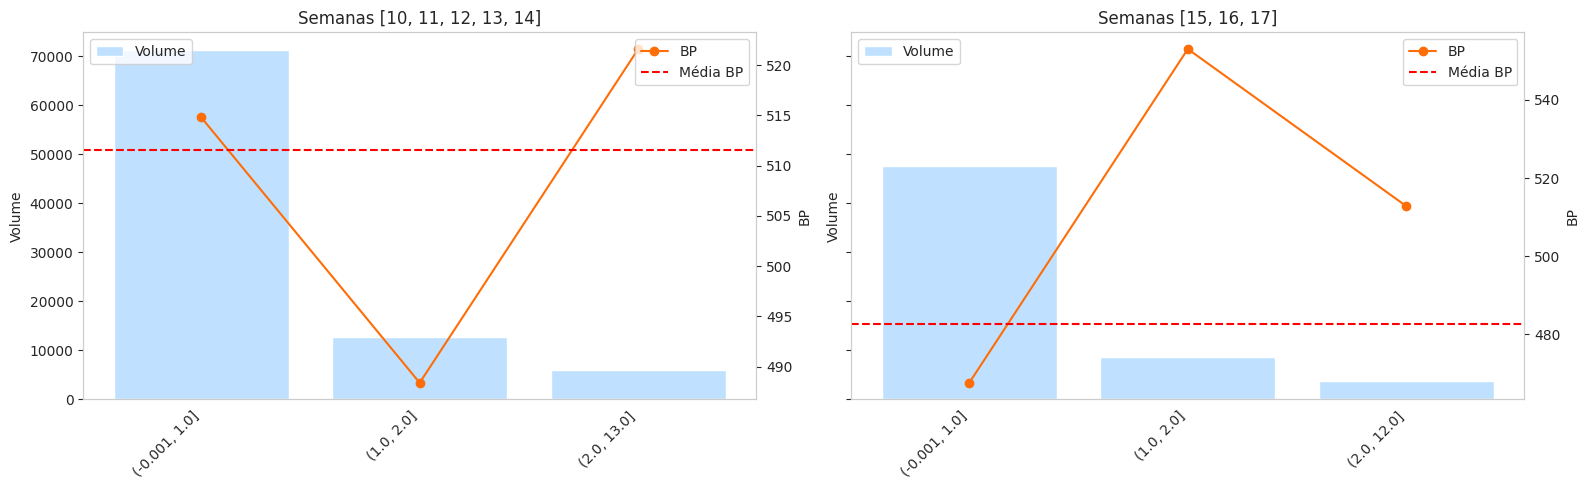

In [138]:
check_bad_var_compare(df, var='i_num_count_sep', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

ainda nao da para usar (não é estavel a discriminação ao longo do tempo)

In [139]:
df['i_num_count_sep_agrup'] = df.i_num_count_sep.apply(lambda x: '<2' if x<2 else '>=2')

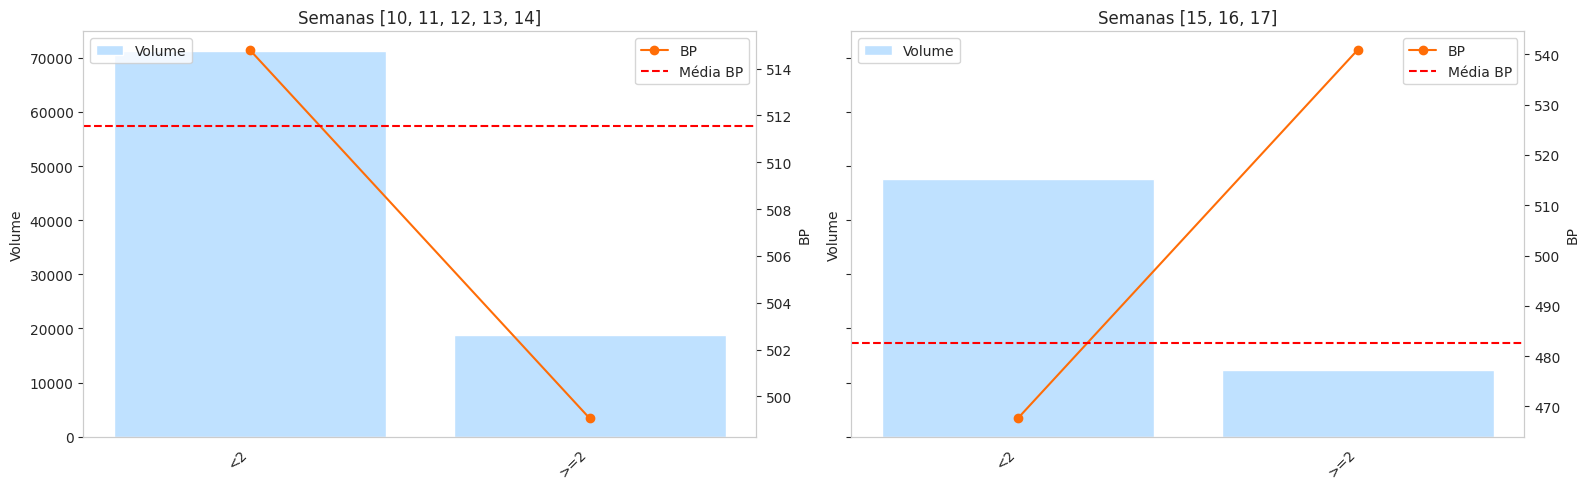

In [140]:
check_bad_var_compare(df, var='i_num_count_sep_agrup', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

ainda nao da para usar

**Observações**
* Variável demonstra comportamento diferente no OOT
---
**Comentários**
* não usar

##### Análise de estabilidade X BP de palavras no texto

In [141]:
from wordcloud import WordCloud, STOPWORDS

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [143]:
def clean_text(text):
    """Lowercase and remove punctuation."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_tfidf_frequencies(text_series, stopwords, max_features=100):
    """
    Computes average TF-IDF scores for a series of documents.

    Parameters:
      text_series (pd.Series): Series of text documents.
      stopwords (set): Set of stopwords to filter.
      max_features (int): Maximum number of features to consider.

    Returns:
      dict: Mapping of word -> average TF-IDF score.
    """
    vectorizer = TfidfVectorizer(stop_words=list(stopwords), max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(text_series)
    # Compute average score for each term (across documents)
    avg_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()
    freq_dict = dict(zip(words, avg_scores))
    return freq_dict

def plot_significant_fraud_words_over_time(df, text_col, fraud_col, train_weeks, oot_weeks, fraud_value=1, max_features=100, wc_kwargs={}):
    """
    Creates a 2x2 grid of word clouds using TF-IDF weighting to highlight significant words.
    The grid compares training and OOT periods, splitting each by fraudulent vs. non-fraudulent entries.

    Parameters:
      df: DataFrame containing your data.
      text_col: Column with product names (text).
      fraud_col: Column indicating fraud flag (e.g., 1 for fraud).
      train_weeks: List of weeks corresponding to the training period.
      oot_weeks: List of weeks corresponding to the OOT period.
      fraud_value: The value in fraud_col that indicates fraud (default=1).
      max_features: Maximum number of features to consider in TF-IDF.
      wc_kwargs: Additional keyword arguments for WordCloud (e.g., width, height, max_words).
    """
    # Define custom stopwords (Portuguese and Spanish)
    stopwords_pt = {
        "de", "a", "o", "que", "e", "do", "da", "em", "um", "para", "é", "com",
        "não", "uma", "os", "no", "se", "na", "por", "mais", "as", "dos", "como",
        "mas", "foi", "ao", "ele", "das", "tem", "à", "seu", "sua", "ou", "ser",
        "quando", "muito", "há", "nos", "já", "está", "eu", "também", "só", "pelo",
        "pela", "até", "isso", "ela", "entre", "era", "depois", "sem", "mesmo",
        "aos", "seus", "quem", "nas", "me", "esse", "eles", "estão", "você",
        "tinha", "foram", "essa", "num", "nem", "suas", "meu", "às", "minha",
        "têm", "numa", "pelos", "elas", "havia", "seja", "qual", "será", "nós",
        "tenho", "lhe", "deles", "essas", "esses", "pelas", "este", "dele", "tu",
        "te", "vocês", "vos", "lhes", "meus", "minhas", "teu", "tua", "teus", "tuas",
        "nosso", "nossa", "nossos", "nossas", "dela", "delas", "esta", "estes",
        "estas", "aquele", "aquela", "aqueles", "aquelas", "isto", "aquilo"
    }
    stopwords_es = {
        "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las", "por",
        "un", "para", "con", "no", "una", "su", "al", "lo", "como", "más", "pero",
        "sus", "le", "ya", "o", "este", "sí", "porque", "esta", "entre", "cuando",
        "muy", "sin", "sobre", "también", "me", "hasta", "hay", "donde", "quien",
        "desde", "todo", "nos", "durante", "todos", "uno", "les", "ni", "contra",
        "otros", "ese", "eso", "ante", "ellos", "e", "esto", "mí", "antes",
        "algunos", "qué", "unos", "yo", "otro", "otras", "otra", "él", "tanto",
        "esa", "estos", "mucho", "quienes", "nada", "muchos", "cual", "poco",
        "ella", "estar", "estas", "algunas", "algo", "nosotros", "mi", "mis", "tú",
        "te", "ti", "tu", "tus", "ellas", "nosotras", "vosotros", "vosotras", "os",
        "mío", "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "suyo",
        "suya", "suyos", "suyas", "nuestro", "nuestra", "nuestros", "nuestras",
        "vuestro", "vuestra", "vuestros", "vuestras", "esos", "esas", "estoy",
        "estás", "está", "estamos", "estáis", "están", "esté", "estés", "estemos",
        "estéis", "estén"
    }
    custom_stopwords = STOPWORDS.union(stopwords_pt).union(stopwords_es)

    # Filter data for training and OOT periods
    df_train = df[df['week'].isin(train_weeks)].copy()
    df_oot   = df[df['week'].isin(oot_weeks)].copy()

    # Clean the text column
    df_train[text_col] = df_train[text_col].astype(str).apply(clean_text)
    df_oot[text_col]   = df_oot[text_col].astype(str).apply(clean_text)

    # Split each period into fraud and non-fraud groups
    groups = {
        "Training - Fraudulent": df_train[df_train[fraud_col] == fraud_value],
        "Training - Non-Fraudulent": df_train[df_train[fraud_col] != fraud_value],
        "OOT - Fraudulent": df_oot[df_oot[fraud_col] == fraud_value],
        "OOT - Non-Fraudulent": df_oot[df_oot[fraud_col] != fraud_value]
    }

    # Compute TF-IDF frequencies for each group
    tfidf_dicts = {}
    for group_name, group_df in groups.items():
        # Use individual product names as documents
        if group_df.empty:
            tfidf_dicts[group_name] = {}
        else:
            tfidf_dicts[group_name] = get_tfidf_frequencies(group_df[text_col], custom_stopwords, max_features=max_features)

    # Generate word clouds from the TF-IDF frequencies
    wordclouds = {}
    for group_name, freq_dict in tfidf_dicts.items():
        wordclouds[group_name] = WordCloud(background_color='white', stopwords=custom_stopwords, **wc_kwargs).generate_from_frequencies(freq_dict)

    # Plot the word clouds in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(8,6))
    group_names = list(groups.keys())
    for idx, ax in enumerate(axes.flatten()):
        group_name = group_names[idx]
        if tfidf_dicts[group_name]:
            ax.imshow(wordclouds[group_name], interpolation='bilinear')
        else:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', fontsize=20)
        ax.axis('off')
        ax.set_title(group_name, fontsize=16)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


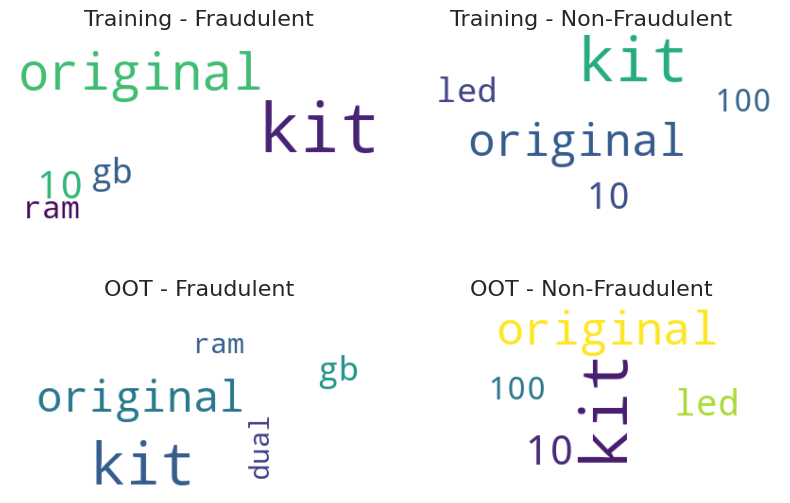

In [144]:
plot_significant_fraud_words_over_time(
    df,
    text_col='i',
    fraud_col='fraude',
    train_weeks=[10, 11, 12, 13, 14],
    oot_weeks=[15, 16, 17],
    max_features=5,
)

###### Analise palavra original

In [145]:
df['i_word_original'] = df.i.str.lower().str.contains('original').astype(int)

In [146]:
df[df.week.isin([10, 11, 12, 13, 14])&(df['i_word_original']==1)].shape[0]/df[df.week.isin([10, 11, 12, 13, 14])].shape[0]

0.054783873510764684

In [147]:
df[df.week.isin([15, 16, 17])&(df['i_word_original']==1)].shape[0]/df[df.week.isin([15, 16, 17])].shape[0]

0.05245507783172331

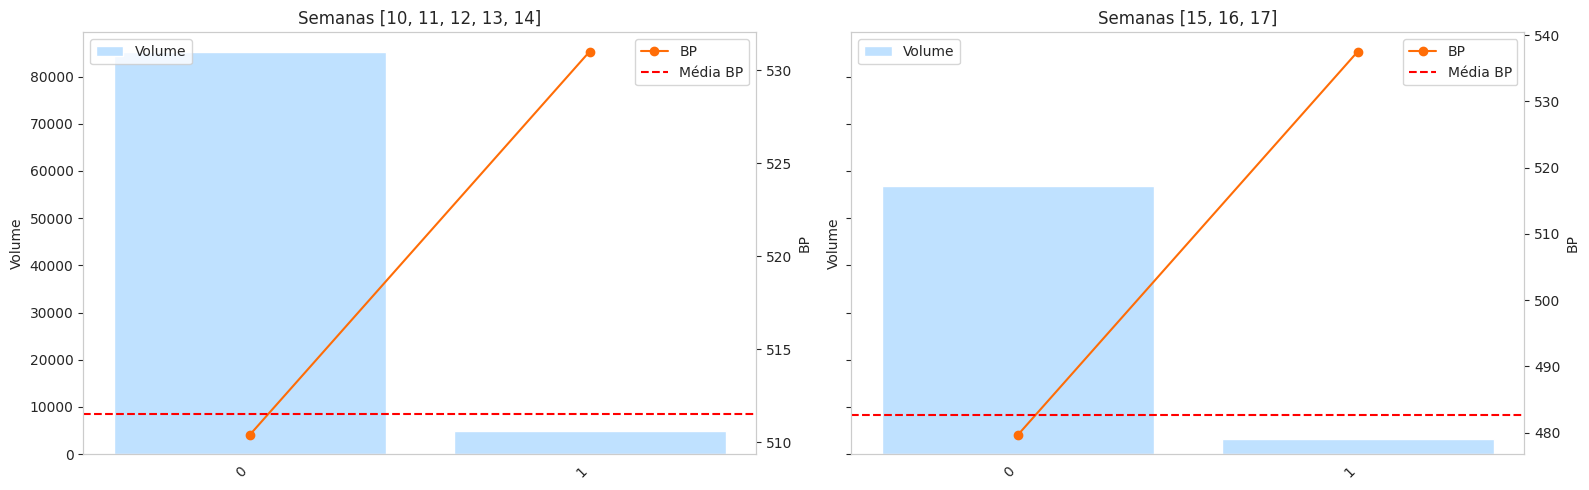

In [148]:
check_bad_var_compare(df, var='i_word_original',
                      target='fraude',
                      tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Maior fraude quando a palavra está presente no texto
* sem nulos
---
**Comentários**
* Possibilidade de usar variável agrupada como binária

###### Analise palavra kit

In [149]:
df['i_word_kit'] = df.i.str.lower().str.contains('kit').astype(int)

In [150]:
df[df.week.isin([10, 11, 12, 13, 14])&(df['i_word_kit']==1)].shape[0]/df[df.week.isin([10, 11, 12, 13, 14])].shape[0]

0.1196606819670675

In [151]:
df[df.week.isin([15, 16, 17])&(df['i_word_kit']==1)].shape[0]/df[df.week.isin([15, 16, 17])].shape[0]

0.1194420808515608

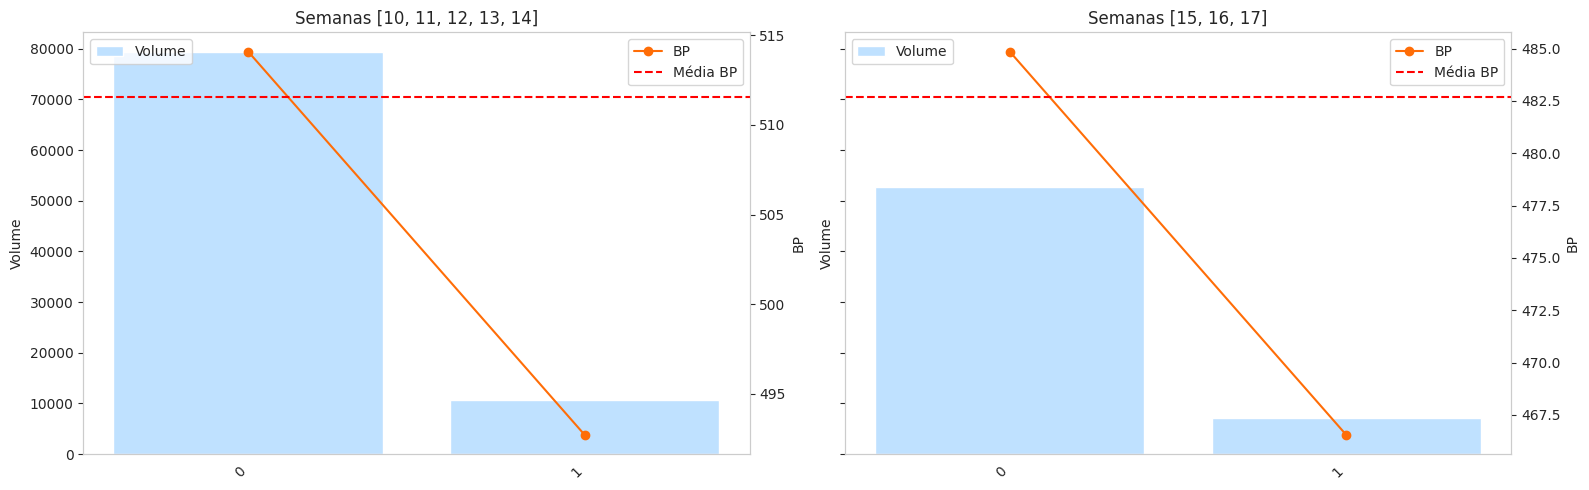

In [152]:
check_bad_var_compare(df, var='i_word_kit',
                      target='fraude',
                      tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Maior fraude quando a palavra não está presente no texto
* sem nulos
---
**Comentários**
* Possibilidade de usar variável agrupada como binária

###### Analise palavra gb

In [153]:
df['i_word_gb'] = df.i.str.lower().str.contains('gb').astype(int)

In [154]:
df[df.week.isin([10, 11, 12, 13, 14])&(df['i_word_gb']==1)].shape[0]/df[df.week.isin([10, 11, 12, 13, 14])].shape[0]

0.03027880483661437

In [155]:
df[df.week.isin([15, 16, 17])&(df['i_word_gb']==1)].shape[0]/df[df.week.isin([15, 16, 17])].shape[0]

0.03288452875519295

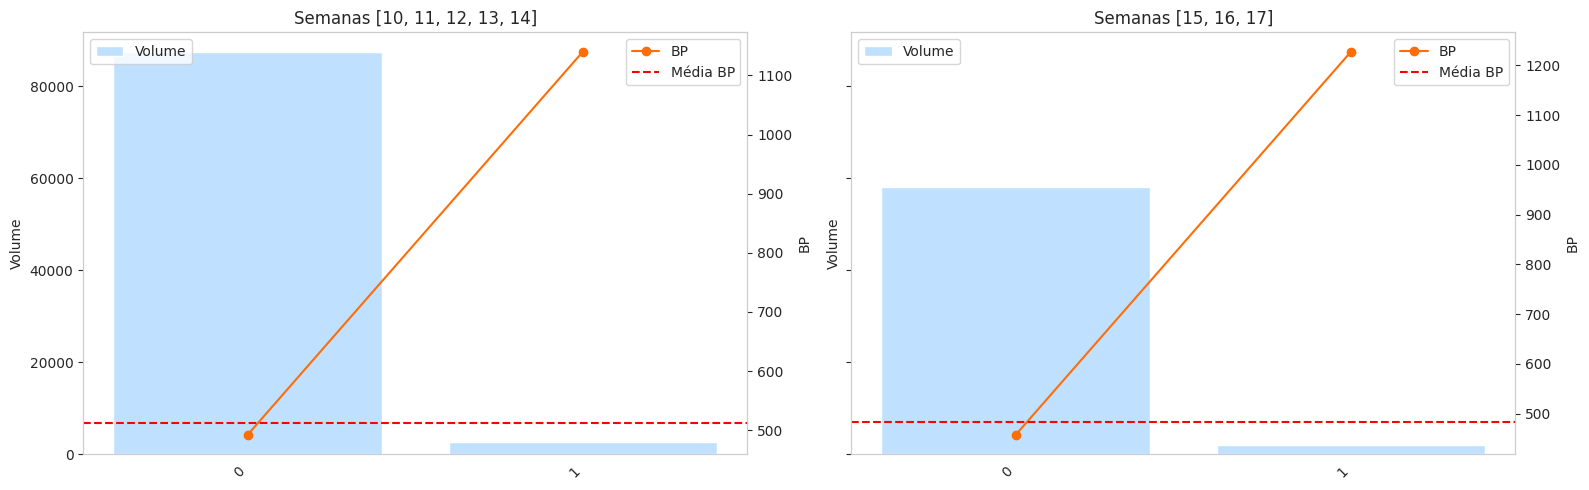

In [156]:
check_bad_var_compare(df, var='i_word_gb',
                      target='fraude',
                      tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Maior fraude quando a palavra está presente no texto
* sem nulos
---
**Comentários**
* Possibilidade de usar variável agrupada como binária

###### Analise palavra ram

In [157]:
df['i_word_ram'] = df.i.str.lower().str.contains('ram').astype(int)

In [158]:
df[df.week.isin([10, 11, 12, 13, 14])&(df['i_word_ram']==1)].shape[0]/df[df.week.isin([10, 11, 12, 13, 14])].shape[0]

0.0283135138736218

In [159]:
df[df.week.isin([15, 16, 17])&(df['i_word_ram']==1)].shape[0]/df[df.week.isin([15, 16, 17])].shape[0]

0.02924737641189916

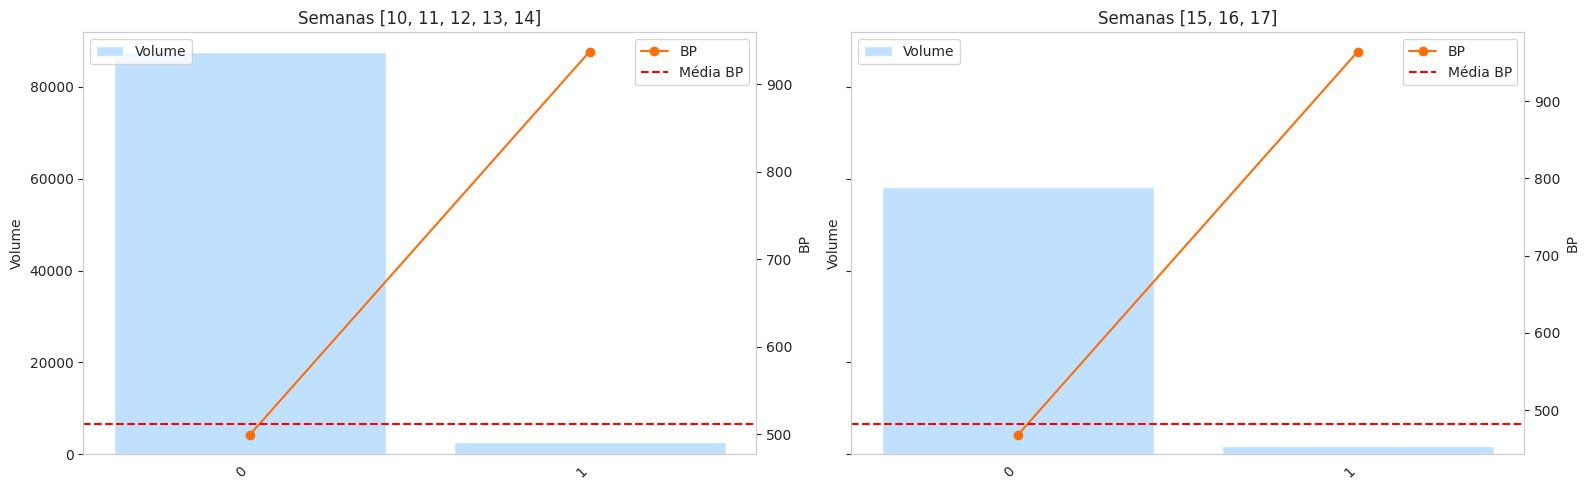

In [160]:
check_bad_var_compare(df, var='i_word_ram',
                      target='fraude',
                      tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

**Observações**
* Variável demonstra comportamento similar no OOT dado sua capacidade de discriminar a fraude
* Maior fraude quando a palavra está presente no texto
* sem nulos
---
**Comentários**
* Possibilidade de usar variável agrupada como binária

###### Análise tokenizador simples (tfidf)

In [161]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

In [162]:
df['i_cleaned'] = (
  df['i']
  .str.lower()
  .apply(remove_accents)
  .str.replace(r'[^\w\s]', '', regex=True)
  )

In [163]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [164]:
def compare_ngram_ranges(df, text_col, label_col, ngram_ranges=[(1,1), (1,2), (2,2)]):
    """
    1) Splits data into train/test.
    2) For each ngram_range:
       - Vectorizes text with TF-IDF
       - Trains a Logistic Regression
       - Evaluates performance on TRAIN and TEST (precision, recall, F1, AUC)
       - Prints top positive/negative features
    """
    # Split data (adjust test_size or random_state as needed)
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col],
        df[label_col],
        test_size=0.33,
        random_state=42,
        stratify=df[label_col]  # keeps label distribution consistent
    )

    for ngram in ngram_ranges:
        print(f"\n=== N-gram range: {ngram} ===")

        # 1. Vectorize text with TF-IDF
        vectorizer = TfidfVectorizer(ngram_range=ngram, stop_words=['spanish', 'portuguese'], max_features=500)
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        # 2. Train a simple classifier
        clf = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)
        clf.fit(X_train_vec, y_train)

        # ---------------------------
        # EVALUATE ON TRAIN
        # ---------------------------
        y_train_pred = clf.predict(X_train_vec)
        y_train_prob = clf.predict_proba(X_train_vec)[:, 1]

        train_report = classification_report(y_train, y_train_pred)
        train_auc = roc_auc_score(y_train, y_train_prob)

        print("TRAIN set metrics:")
        print(train_report)
        print(f"Train ROC AUC: {train_auc:.4f}\n")

        # ---------------------------
        # EVALUATE ON TEST
        # ---------------------------
        y_test_pred = clf.predict(X_test_vec)
        y_test_prob = clf.predict_proba(X_test_vec)[:, 1]

        test_report = classification_report(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_prob)

        print("TEST set metrics:")
        print(test_report)
        print(f"Test ROC AUC: {test_auc:.4f}\n")

        # 3. Show top positive/negative words
        feature_names = vectorizer.get_feature_names_out()
        coefs = clf.coef_[0]

        # Indices for top coefficients (most indicative of fraud = label=1)
        top_pos_indices = coefs.argsort()[::-1][:10]
        # Indices for bottom coefficients (most indicative of non-fraud = label=0)
        top_neg_indices = coefs.argsort()[:10]

        print("Top positive words (indicating fraud):")
        for i in top_pos_indices:
            print(f"   {feature_names[i]} ({coefs[i]:.3f})")

        print("Top negative words (indicating non-fraud):")
        for i in top_neg_indices:
            print(f"   {feature_names[i]} ({coefs[i]:.3f})")

In [165]:
compare_ngram_ranges(df, text_col='i_cleaned', label_col='fraude', ngram_ranges=[(1,1), (1,2), (2,2)])


=== N-gram range: (1, 1) ===
TRAIN set metrics:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     95475
           1       0.08      0.56      0.14      5025

    accuracy                           0.66    100500
   macro avg       0.52      0.61      0.47    100500
weighted avg       0.92      0.66      0.76    100500

Train ROC AUC: 0.6649

TEST set metrics:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     47025
           1       0.07      0.49      0.12      2475

    accuracy                           0.65     49500
   macro avg       0.52      0.58      0.45     49500
weighted avg       0.92      0.65      0.75     49500

Test ROC AUC: 0.6097

Top positive words (indicating fraud):
   4k (1.954)
   70 (1.880)
   tapete (1.866)
   fire (1.858)
   8gb (1.826)
   ouro (1.795)
   oficial (1.538)
   iphone (1.512)
   play (1.473)
   32gb (1.423)
Top negative words (indicating no

**Observações**
* limitar a 2 ngramas somente parece aumentar o overfit do modelo, o que faz sentido pois voce diminui a probabilidade daquele grama aparecer novamente
* sem nulos
---
**Comentários**
* usar ngramas de 1 a 2 parece ser a melhor opção pois ,

#### Analisando a variável j

##### Analise inicial

In [166]:
df.j.head(5).reset_index().T

0            1            2            3            4
index            0            1            2            3            4
j      cat_8d714cd  cat_64b574b  cat_e9110c5  cat_d06e653  cat_6c4cfdc

In [167]:
df.j.nunique()

8324

In [168]:
df.j.value_counts(normalize=True).cumsum().reset_index().T

0            1            2            3            4     \
j           cat_43b9c10  cat_d69bed9  cat_604df77  cat_6c4cfdc  cat_4249bd8   
proportion      0.01554     0.027533     0.039427     0.049087     0.057027   

                   5            6            7            8            9     \
j           cat_3203c7c  cat_be0af8e  cat_0820fab  cat_8ef7164  cat_d5975ae   
proportion     0.064313     0.071247       0.0775      0.08356     0.089413   

                   10           11           12           13           14    \
j           cat_f0ec611  cat_960e53d  cat_0eb83e7  cat_e600e6d  cat_ffe7351   
proportion      0.09458     0.099613       0.1046     0.109327     0.113887   

                   15           16           17           18           19    \
j           cat_ec06c68  cat_381751d  cat_0f47e2a  cat_9bacaa5  cat_2d99b60   
proportion       0.1183     0.122673        0.127     0.131273     0.135387   

                   20           21           22           23           24    \
j           cat_45398dd  cat_8d714cd  cat_228843f  cat_bdcf37d  cat_9a8fa4c   
proportion     0.139407      0.14342     0.147433     0.151147     0.154827   

                   25           26           27           28           29    \
j           cat_89ea11f  cat_7d79cff  cat_4109cab  cat_a2bca79  cat_e41d6ce   
proportion     0.158447      0.16192     0.165367      0.16874     0.172073   

                   30           31           32           33           34    \
j           cat_9ff11b9  cat_a349b79  cat_b7febb2  cat_1104aa0  cat_72781ea   
proportion     0.175393     0.178667     0.181887      0.18504     0.188113   

                   35           36           37           38           39    \
j           cat_5d6059e  cat_d9753d4  cat_237e2d0  cat_20525f8  cat_5b4c8c8   
proportion     0.191173     0.194193     0.197187      0.20016     0.202893   

                   40           41           42           43           44    \
j           cat_cb0afa0  cat_b23deda  cat_9eaf019  cat_535337c  cat_1d61c62   
proportion     0.205593     0.208113     0.210573     0.213007     0.215413   

                   45           46           47           48           49    \
j           cat_a4921b8  cat_e5ca240  cat_9c39285  cat_d69d46a  cat_2eabef6   
proportion     0.217813     0.220167     0.222507      0.22484     0.227153   

                   50           51           52           53           54    \
j           cat_23212a0  cat_2da13b3  cat_62a4e2c  cat_1025606  cat_21ac14d   
proportion      0.22946     0.231673     0.233887     0.236087     0.238273   

                   55           56           57           58           59    \
j           cat_048130a  cat_d55eb54  cat_10ef367  cat_297d68e  cat_8ffef58   
proportion     0.240413     0.242533      0.24464       0.2467     0.248727   

                   60           61           62           63           64    \
j           cat_71f63b5  cat_12a8b9b  cat_d5f76af  cat_336e357  cat_2c670e8   
proportion     0.250753     0.252767      0.25478     0.256787     0.258793   

                   65           66           67           68           69    \
j           cat_9eff754  cat_1cce58b  cat_ea962fb  cat_8f5bd9e  cat_e790de8   
proportion     0.260753       0.2627     0.264647      0.26654      0.26842   

                   70           71           72           73           74    \
j           cat_b50d9ab  cat_aa51e22  cat_a11afcf  cat_c8fff07  cat_0f6c6e1   
proportion     0.270293     0.272133     0.273953     0.275727     0.277493   

                   75           76           77           78           79    \
j           cat_a28270e  cat_262daa6  cat_bba902e  cat_0dc7bc3  cat_c20125f   
proportion     0.279253     0.280993     0.282693      0.28438     0.286053   

                   80           81           82           83           84    \
j           cat_1a392e2  cat_7ccaf9e  cat_b51ba8a  cat_c84c9c3  cat_b7aad39   
proportion     0.287727     0.289393      0.29106    

Categórica e aparenta apresentar a categoria do produto, porém contém um alto número de categorias

##### Análise de nulos

In [169]:
df.j.isna().sum()

0

sem nulos

###### Clusterizando categorias

In [170]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [171]:
df_agg = df.groupby('j').agg(
    mean_fraude=('fraude', 'mean'),   # taxa média de fraude
    sum_fraude=('fraude', 'sum'),       # total de fraudes
    mean_monto=('monto', 'mean'),       # valor médio
    sum_monto=('monto', 'sum'),         # valor total
    count=('monto', 'count')            # número de transações
).reset_index()

In [172]:
X = df_agg[['mean_fraude', 'sum_fraude', 'mean_monto', 'sum_monto', 'count']]

In [173]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [174]:
sil_scores = []
K_range = range(2, 20)  # Testa de 2 até 10 clusters

In [175]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f'k: {k}, Silhouette Score: {sil:.4f}')

k: 2, Silhouette Score: 0.9220
k: 3, Silhouette Score: 0.7465
k: 4, Silhouette Score: 0.8214
k: 5, Silhouette Score: 0.8236
k: 6, Silhouette Score: 0.7416
k: 7, Silhouette Score: 0.7254
k: 8, Silhouette Score: 0.7127
k: 9, Silhouette Score: 0.5623
k: 10, Silhouette Score: 0.5794
k: 11, Silhouette Score: 0.5711
k: 12, Silhouette Score: 0.5726
k: 13, Silhouette Score: 0.5727
k: 14, Silhouette Score: 0.5667
k: 15, Silhouette Score: 0.5665
k: 16, Silhouette Score: 0.5781
k: 17, Silhouette Score: 0.5804
k: 18, Silhouette Score: 0.5734
k: 19, Silhouette Score: 0.5903


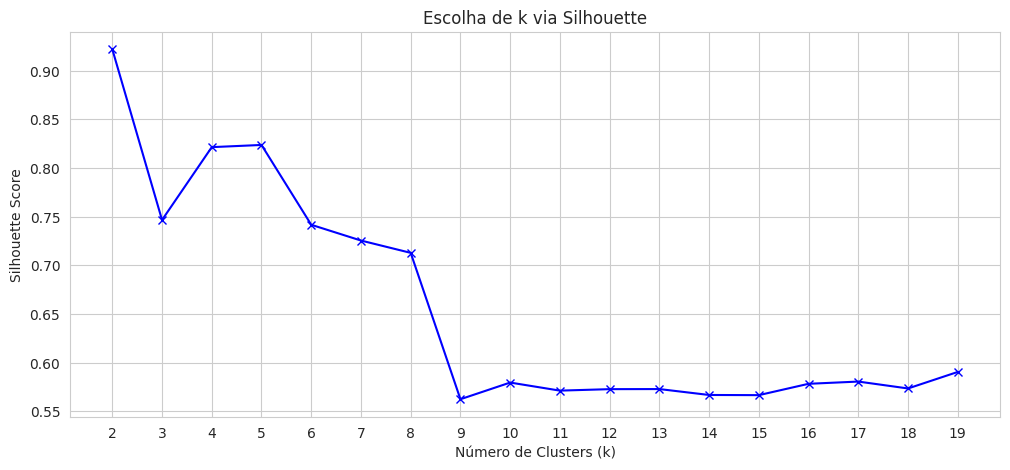

In [176]:
plt.figure(figsize=(12, 5))
plt.plot(K_range, sil_scores, 'bx-')
plt.xticks(K_range)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Escolha de k via Silhouette')
plt.show()

In [177]:
optimal_k = 9

In [178]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

In [179]:
df_agg['j_cluster'] = kmeans.fit_predict(X_scaled)

In [181]:
df = df.merge(df_agg[['j', 'j_cluster']], on='j', how='left')

##### Análise de estabilidade X BP

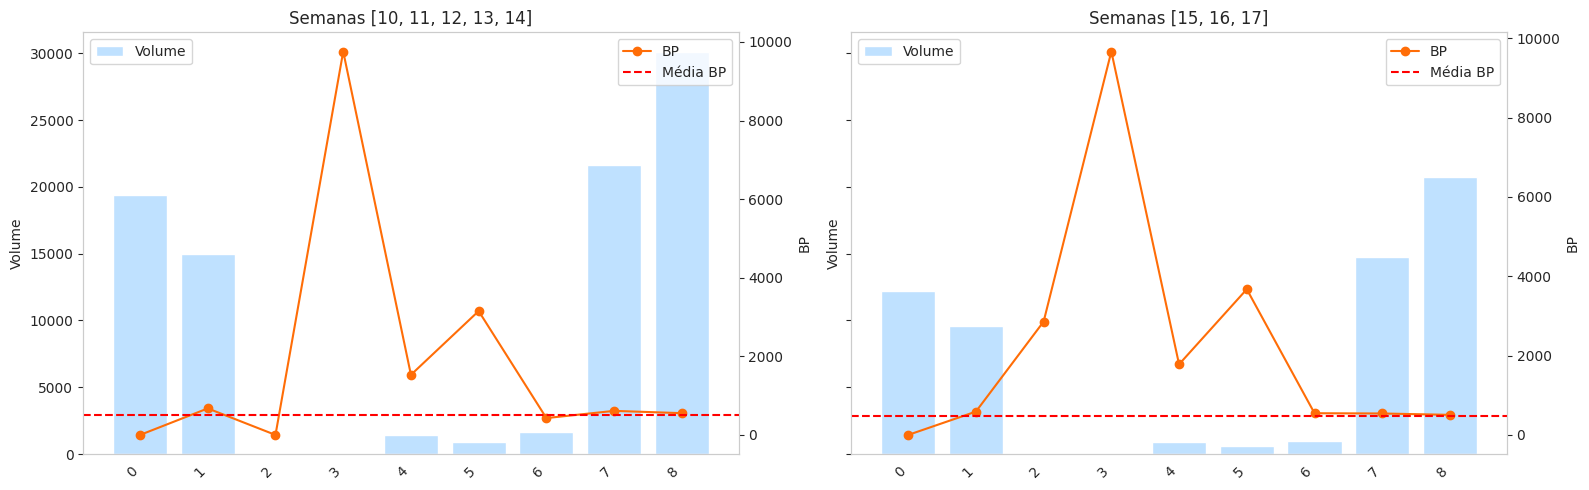

In [182]:
check_bad_var_compare(df, var='j_cluster', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

In [183]:
df['j_cluster_agrup'] = df['j_cluster'].apply(lambda x: 1 if x in [3,4,5] else 0)

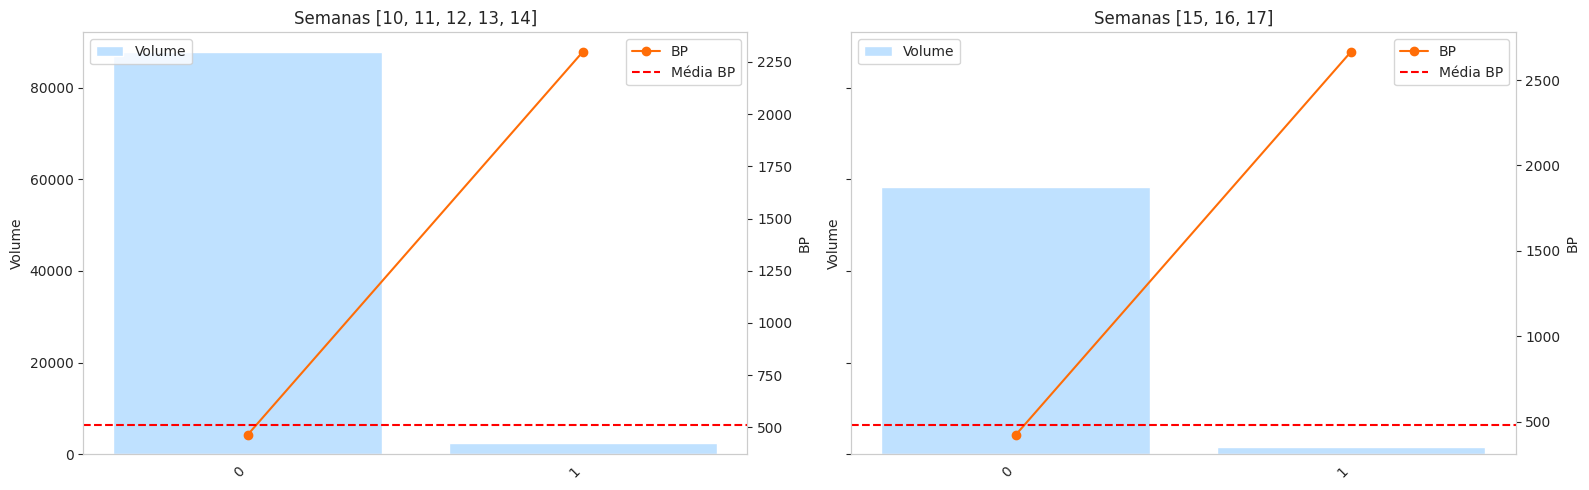

In [184]:
check_bad_var_compare(df, var='j_cluster_agrup', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

In [237]:
mapping_dict = dict(zip(df['j'], df['j_cluster']))

In [238]:
print(mapping_dict)

{'cat_8d714cd': 1, 'cat_64b574b': 7, 'cat_e9110c5': 6, 'cat_d06e653': 8, 'cat_6c4cfdc': 1, 'cat_9d78e2e': 7, 'cat_5d6059e': 7, 'cat_e686ce3': 0, 'cat_bfe5d9b': 6, 'cat_5d79fb9': 8, 'cat_4744ece': 0, 'cat_768556e': 8, 'cat_d3aa8de': 6, 'cat_ca18469': 8, 'cat_708c94b': 0, 'cat_82dfc13': 0, 'cat_d9753d4': 1, 'cat_960e53d': 1, 'cat_967e66f': 0, 'cat_43b9c10': 4, 'cat_228843f': 1, 'cat_ef93322': 0, 'cat_0c2c00e': 7, 'cat_8ffef58': 7, 'cat_6d428dc': 0, 'cat_d69bf36': 0, 'cat_d69d46a': 7, 'cat_7dc9c03': 7, 'cat_30deaba': 8, 'cat_db7fe14': 0, 'cat_b5f87fb': 7, 'cat_93bc0b7': 0, 'cat_921d818': 8, 'cat_dcf888f': 8, 'cat_8312b60': 8, 'cat_49d5459': 0, 'cat_8dfbe72': 0, 'cat_048130a': 7, 'cat_6f55b11': 7, 'cat_51f9569': 8, 'cat_e5ca240': 1, 'cat_381751d': 1, 'cat_b7ad66e': 0, 'cat_df60aa8': 7, 'cat_d478fcb': 8, 'cat_34b6b1f': 0, 'cat_50ef9e9': 6, 'cat_851cfbb': 0, 'cat_48a2a38': 0, 'cat_c3ce3bc': 0, 'cat_6b75ad3': 8, 'cat_846b079': 7, 'cat_16839f1': 8, 'cat_820ba12': 8, 'cat_3203c7c': 1, 'cat_8b92

**Observações**
* Variável categórica mas com muitos valores disponíveis
* Clusterização trouxe resultados bons para discrminação da fraude
* Alguns cluster de categorias com Bp muito alto
* Grupos com BP alto têm baixo volume
* somente cluster 2 com uma variação no primeiro gráfico

---

**Comentários**
* Maior facilidade de utilziar a variável agrupada como no segundo gráfico de forma binária
* Primeiro gráfico em contrapartida mostra um BP altissimo para alguns clusters de categorias

#### Analisando a variável k

##### Analise inicial

In [185]:
df.k.head(5).reset_index().T

0         1         2         3         4
index  0.000000  1.000000  2.000000  3.000000  4.000000
k      0.883598  0.376019  0.516368  0.154036  0.855798

In [186]:
df.k.describe().reset_index().T

0         1         2         3         4        5         6  \
index     count      mean       std       min       25%      50%       75%   
k      150000.0  0.497532  0.288348  0.000004  0.246819  0.49599  0.746508   

              7  
index       max  
k      0.999995

Aparenta ser numérica aproximadamente de 0 a 1

##### Análise de nulos

In [187]:
df.k.isna().sum()

0

sem nulos

##### Análise de estabilidade X BP

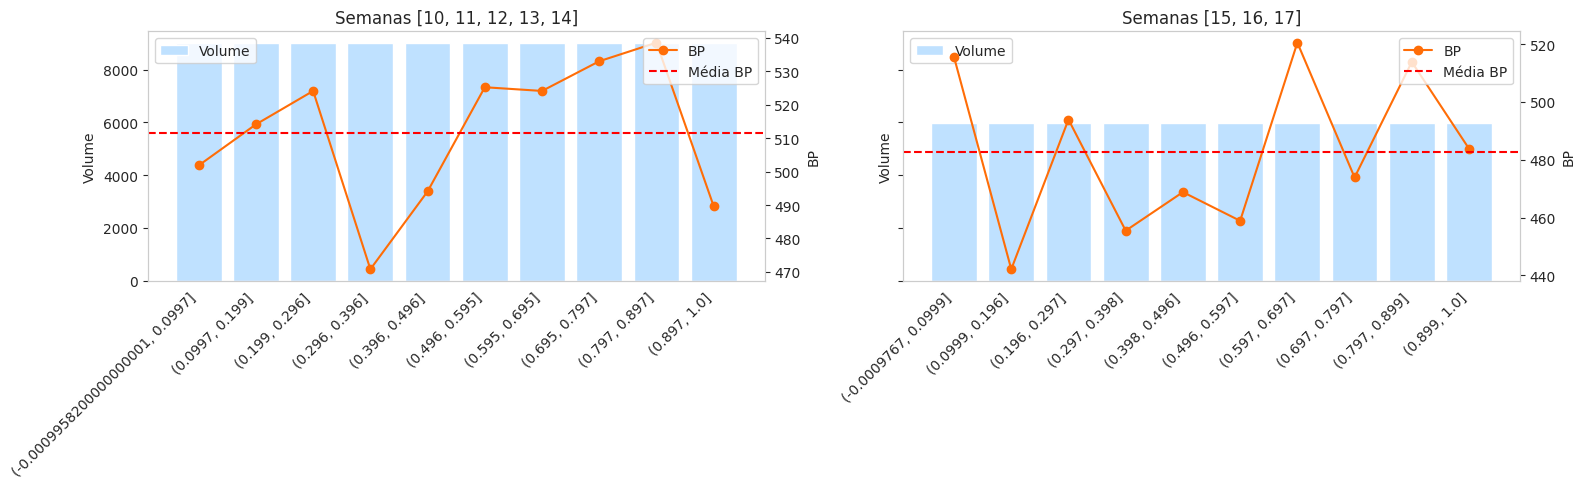

In [188]:
check_bad_var_compare(df, var='k', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

Variavel instavel ao longo do tempo pelo corte acima

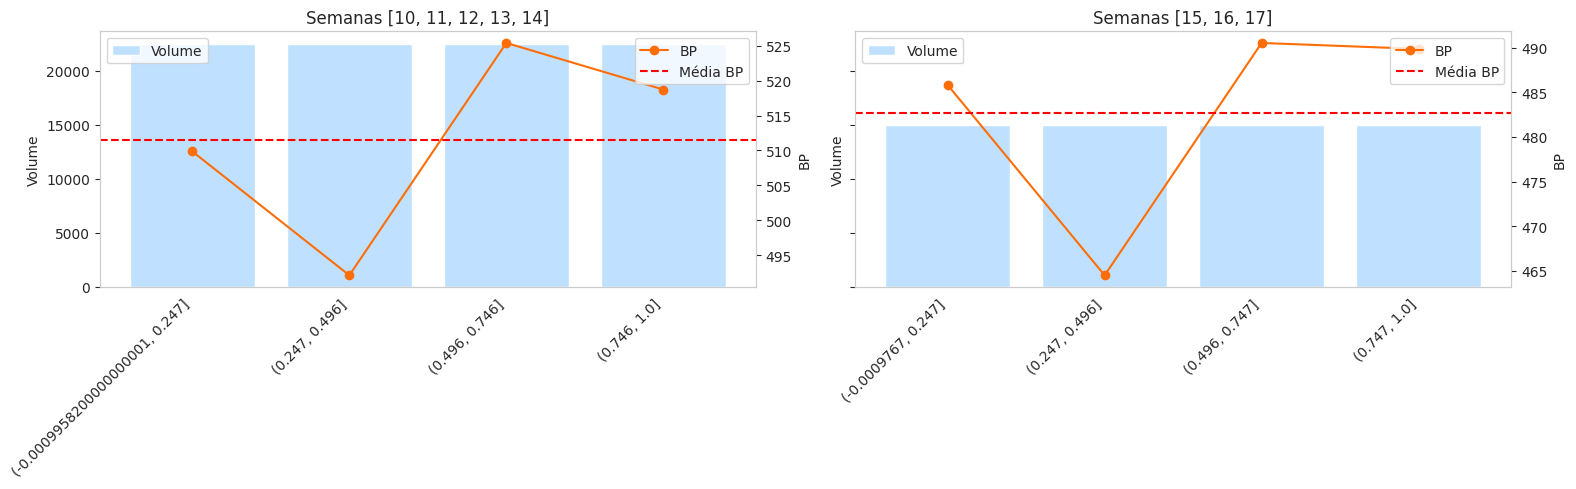

In [189]:
check_bad_var_compare(df, var='k', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=4)

In [240]:
def gera_k(x):
  if x <= 0.247:
    return 0
  elif x <= 0.496:
    return 1
  elif x <= 0.746:
    return 2
  else:
    return 3

In [241]:
df['k_group'] = df['k'].apply(gera_k)

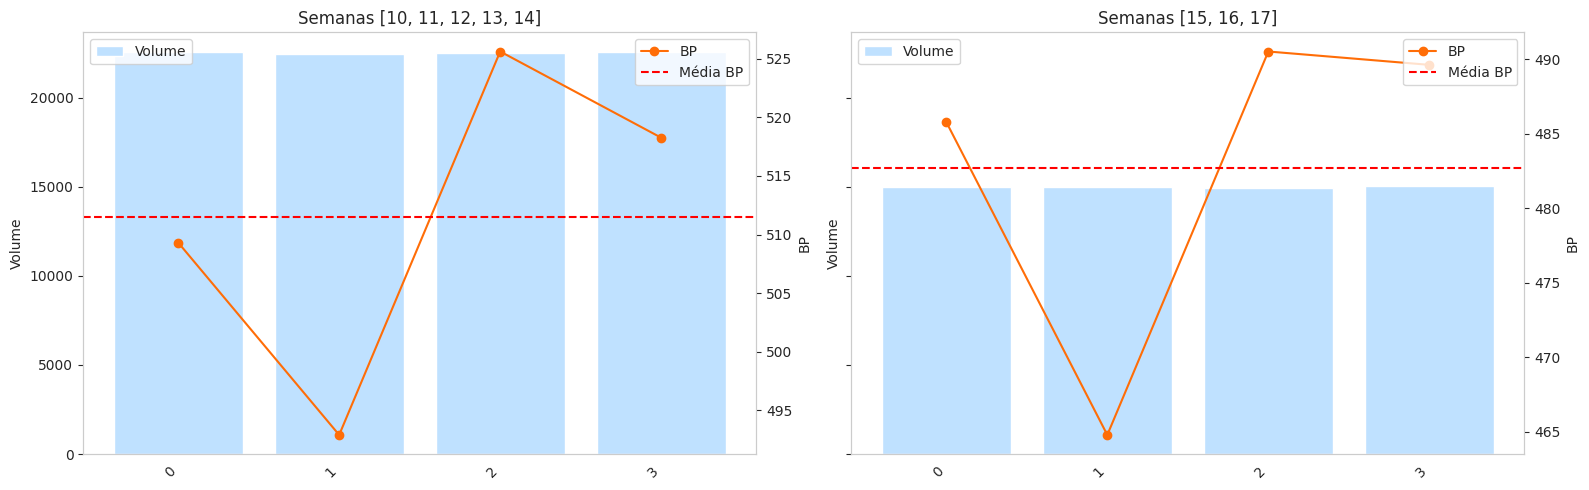

In [244]:
check_bad_var_compare(df, var='k_group', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

Mais estavel

**Observações**
* Variável instável no OOT
* Se discretizada como no corte de 4 quantis fica estável
* A variável não tem nulos

---

**Comentários**
* Discretizar a variavel em quartis

#### Analisando a variável l

##### Analise inicial

In [190]:
df.l.head(5).reset_index().T

0       1       2       3       4
index    0.0     1.0     2.0     3.0     4.0
l      240.0  4008.0  1779.0  1704.0  1025.0

In [191]:
df.l.describe().reset_index().T

0            1            2    3      4       5       6       7
index     count         mean          std  min    25%     50%     75%     max
l      149989.0  2305.409403  1712.379601  0.0  910.0  1937.0  3445.0  7544.0

Aparenta ser numérica contínua

##### Análise de nulos

In [192]:
df.l.isna().sum()

11

muitoo poucos nulos

##### Análise de estabilidade X BP

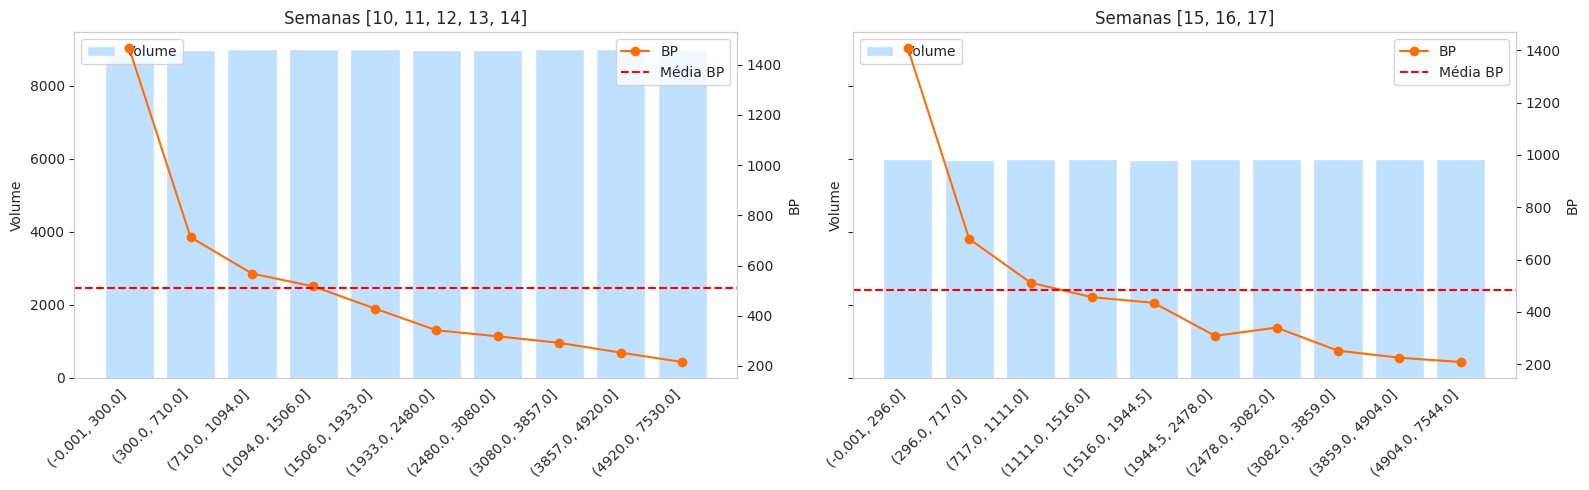

In [193]:
check_bad_var_compare(df, var='l', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

estavel

**Observações**
* Variável estável no OOT tanto volume quanto bad rate
* Variável apresenta decaimento de bad rate a medida que cresce
* A variável tem muito poucos nulos

---

**Comentários**
* Preencher com outliers e utilziar de forma numérica

#### Analisando a variável m

##### Analise inicial

In [194]:
df.m.head(5).reset_index().T

0    1     2       3      4
index    0.0  1.0   2.0     3.0    4.0
m      102.0  0.0  77.0  1147.0  150.0

In [195]:
df.m.describe().reset_index().T

0           1           2    3     4      5      6       7
index     count        mean         std  min   25%    50%    75%     max
m      149635.0  299.969579  321.075806  0.0  42.0  193.0  459.0  2225.0

Aparenta ser numérica contínua

##### Análise de nulos

In [196]:
df.m.isna().sum()

365

muitoo poucos nulos

##### Análise de estabilidade X BP

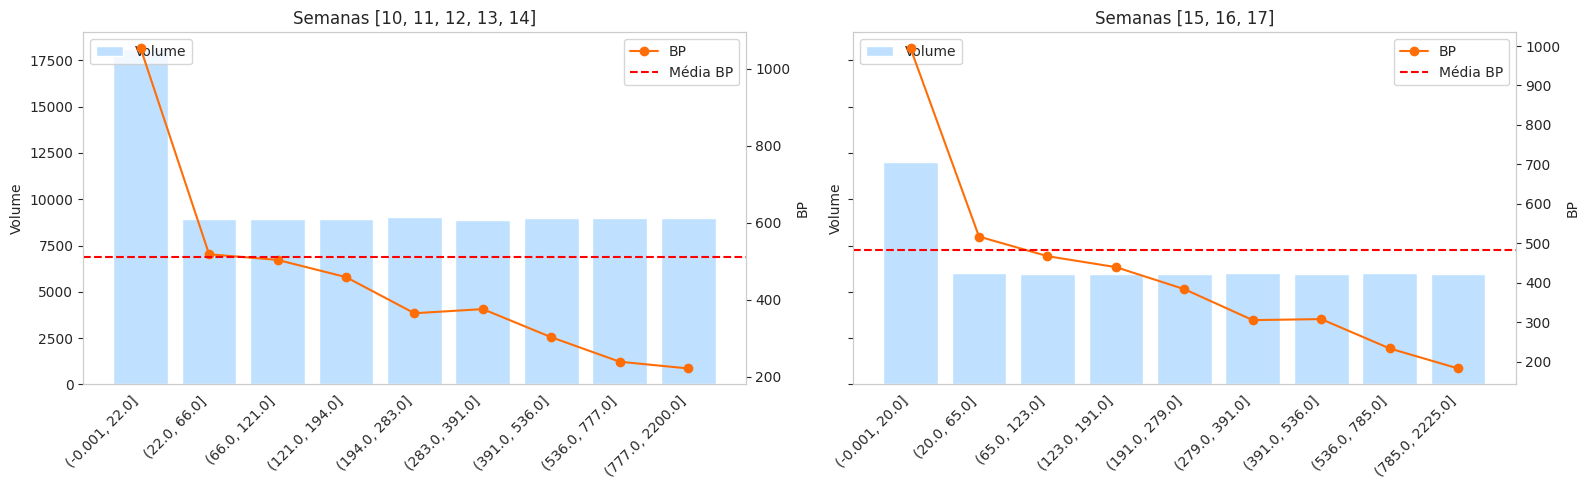

In [197]:
check_bad_var_compare(df, var='m', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

estavel

**Observações**
* Variável estável no OOT tanto volume quanto bad rate
* Variável apresenta decaimento de bad rate a medida que cresce
* A variável tem muito poucos nulos

---

**Comentários**
* Preencher com outliers e utilziar de forma numérica

#### Analisando a variável n

##### Analise inicial

In [198]:
df.n.head(5).reset_index().T

0  1  2  3  4
index  0  1  2  3  4
n      1  1  1  1  1

In [199]:
df.n.value_counts(normalize=True).cumsum().reset_index().T

0    1
n           1.000000  0.0
proportion  0.902353  1.0

Binária

##### Análise de nulos

In [200]:
df.n.isna().sum()

0

sem nulos

##### Análise de estabilidade X BP

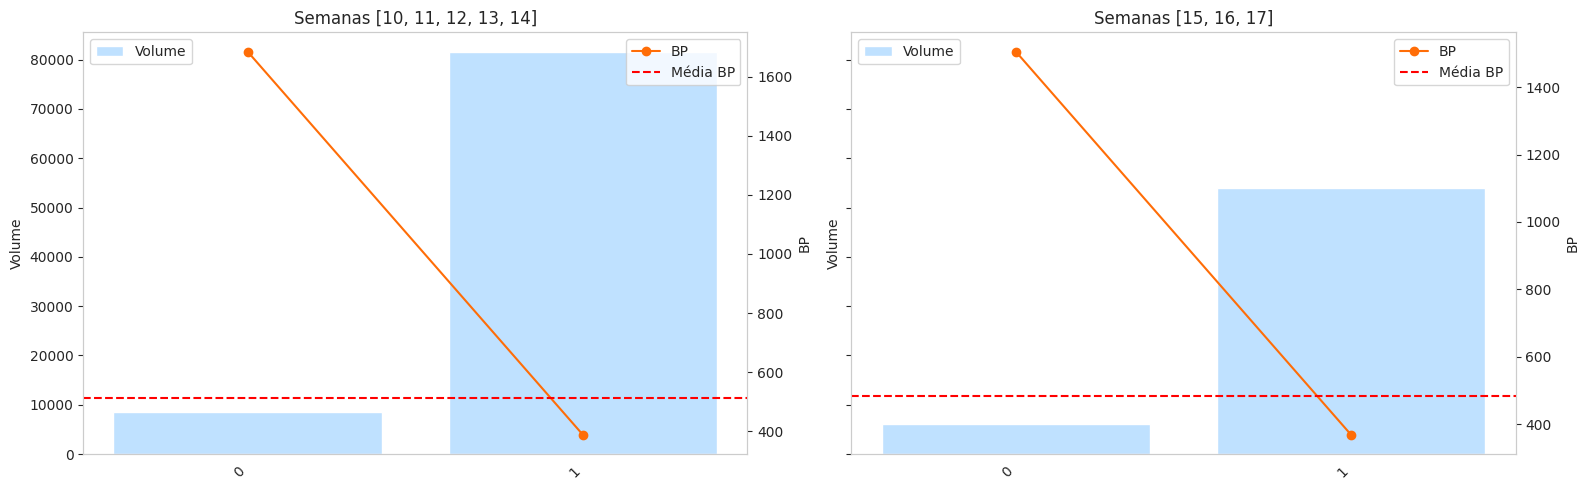

In [201]:
check_bad_var_compare(df, var='n', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,)

estavel

**Observações**
* Variável estável no OOT tanto volume quanto bad rate
* Variável apresenta probabilidade maior de fraude quando = 0
* A variável não tem nulos

---

**Comentários**
* Utilziar como está

#### Analisando a variável o

##### Analise inicial

In [202]:
df.o.head(5).reset_index().T

0  1    2    3    4
index    0  1    2    3    4
o      NaN  Y  NaN  NaN  NaN

In [203]:
df.o.value_counts(normalize=True).cumsum().reset_index().T

0    1
o                  Y    N
proportion  0.585543  1.0

variável binária

##### Análise de nulos

In [204]:
df.o.isna().sum()

108857

In [205]:
df.o.value_counts(normalize=True,dropna=False).cumsum().reset_index().T

0        1    2
o                NaN        Y    N
proportion  0.725713  0.88632  1.0

In [206]:
print('Train:',(df[df['OOT']=='train'].o.isna().sum()/df[df['OOT']=='train'].o.isna().count())*100)
print('Test:',(df[df['OOT']=='test'].o.isna().sum()/df[df['OOT']=='test'].o.isna().count())*100)

Train: 72.47149217769784
Test: 72.72135742529656


muitos nulos porém estável entre treino e teste

In [207]:
df[(df.o.isna())].fraude.sum()/df[(df.o.isna())].fraude.count()

0.020549895734771305

nulos discriminam pouco

##### Análise de estabilidade X BP

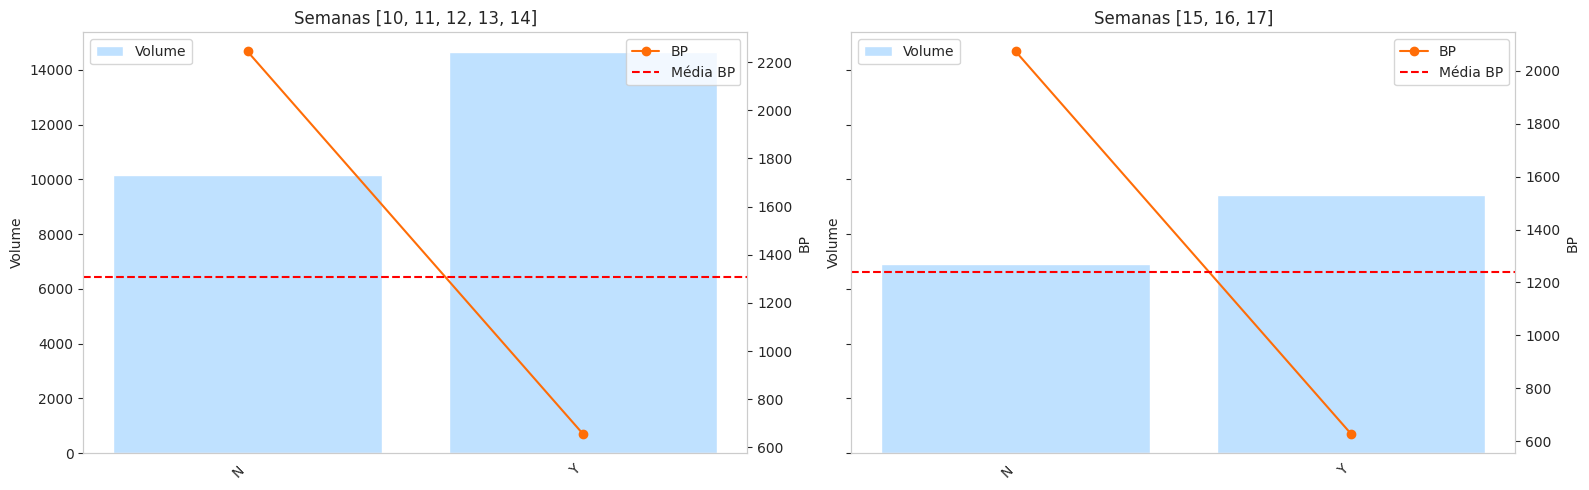

In [208]:
check_bad_var_compare(df, var='o', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

estavel

In [209]:
def trata_o(x):
    if x == 'N' or x == 'n':
        return 0
    elif x == 'Y' or x == 'y':
        return 1
    else:
        return 2

In [210]:
df['o_fill_pos'] = df['o'].apply(trata_o)

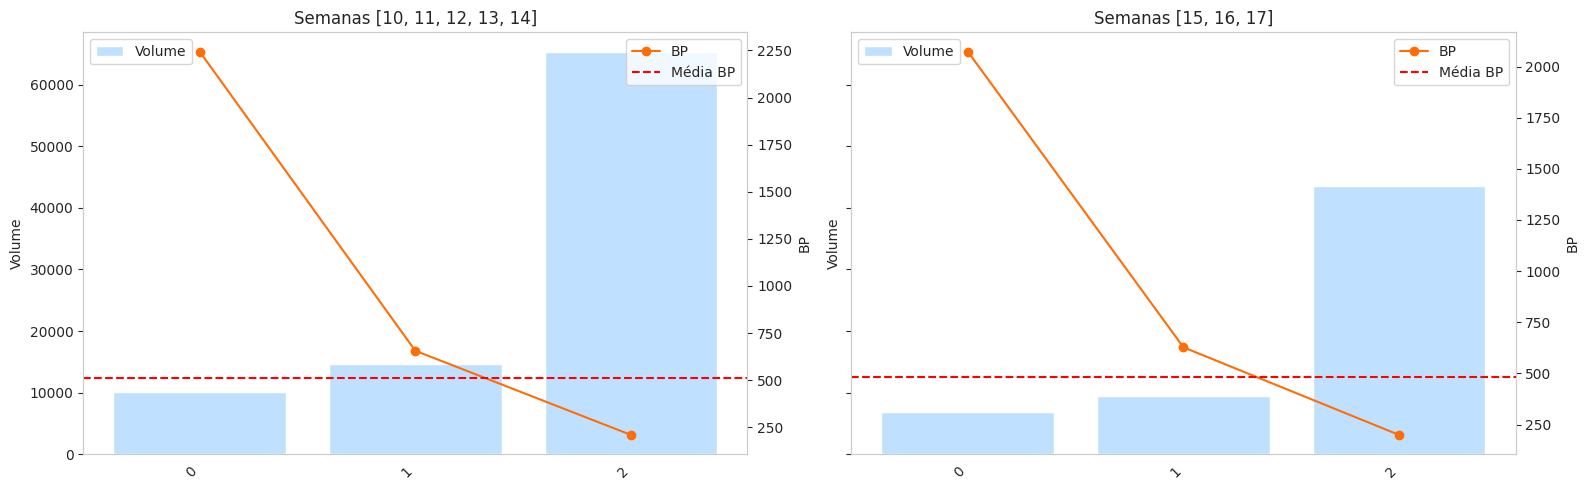

In [211]:
check_bad_var_compare(df, var='o_fill_pos', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

estavel

**Observações**
* Variável estável no OOT tanto volume quanto bad rate
* Variável apresenta decaimento de bad rate para Y e nulo
* A variável tem muitos nulos
* nulos representam baixo BP

---

**Comentários**
* Preencher com 2 os nulos para aproveitar o baixo BP
* transformar em numérica auxilia a ordenar pela bad rate

#### Analisando a variável p

##### Analise inicial

In [212]:
df.p.head(5).reset_index().T

0  1  2  3  4
index  0  1  2  3  4
p      N  N  N  Y  N

In [213]:
df.p.value_counts(normalize=True).cumsum().reset_index().T

0    1
p                  Y    N
proportion  0.554193  1.0

Variável binária

##### Análise de nulos

In [214]:
df.p.isna().sum()

0

sem nulos

nulos discriminam pouco

##### Análise de estabilidade X BP

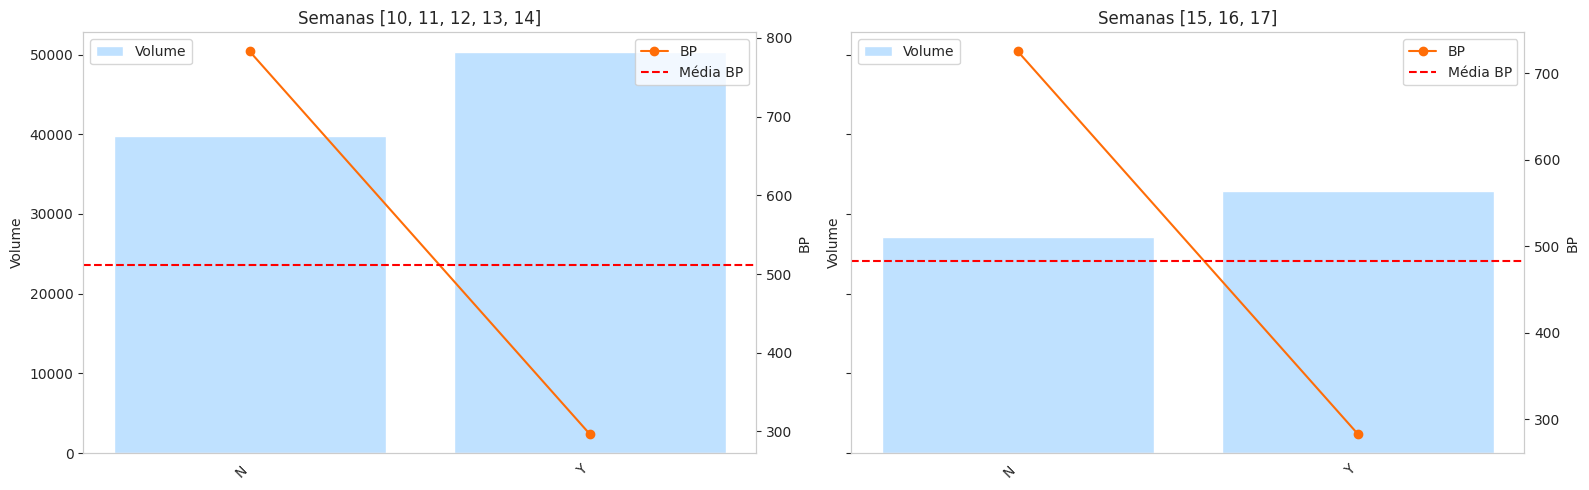

In [215]:
check_bad_var_compare(df, var='p', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

In [216]:
df['p_num'] = df.p.map({'N':0, 'Y':1})

estavel

**Observações**
* Variável estável no OOT tanto volume quanto bad rate
* Variável apresenta BP alto para N e baixo para Y
* A variável não tem nulos

---

**Comentários**
* Possibilidade de binarizar variável para 0 e 1

#### Analisando a variável fecha

##### Analise inicial

In [217]:
df.fecha.head(5).reset_index().T

0                    1                    2  \
index                    0                    1                    2   
fecha  2020-03-27 11:51:16  2020-04-15 19:58:08  2020-03-25 18:13:38   

                         3                    4  
index                    3                    4  
fecha  2020-04-16 16:03:10  2020-04-02 10:24:45

Aparenta ser numérica contínua e o valor do produto

##### Análise de nulos

In [218]:
df.fecha.isna().sum()

0

sem nulos nulos

##### criando dia da semana

In [219]:
df['day_of_week'] = df['fecha'].dt.dayofweek

###### Análise de estabilidade X BP

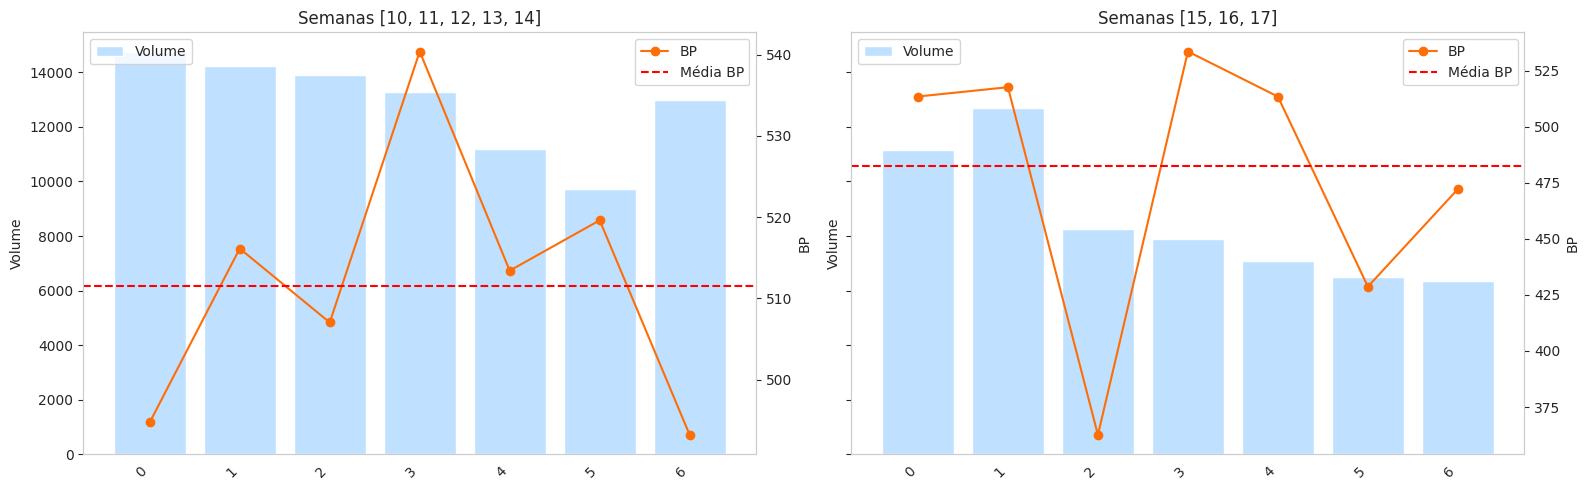

In [220]:
check_bad_var_compare(df, var='day_of_week', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=7)

instável

##### criando final de semana

In [221]:
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

###### Análise de estabilidade X BP

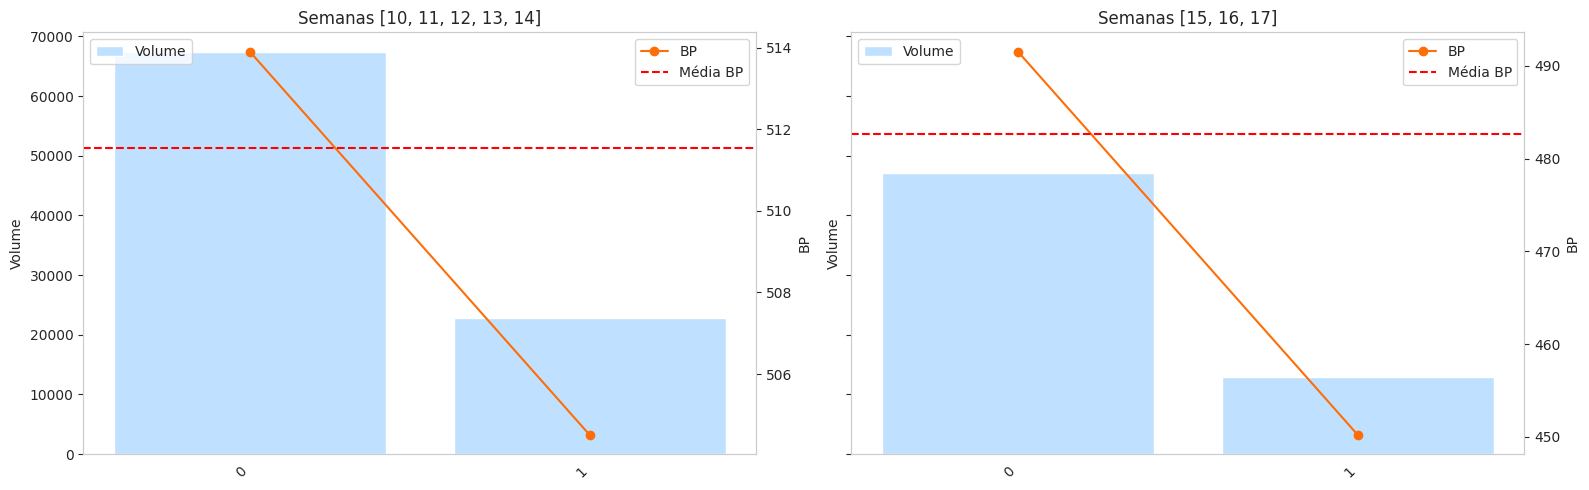

In [222]:
check_bad_var_compare(df, var='is_weekend', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=7)

estável

##### criando periodo do dia

In [223]:
df['hour'] = df['fecha'].dt.hour

In [224]:
bins = [0, 5, 12, 18, 24]
labels = ['madrugada', 'manhã', 'tarde', 'noite']
df['periodo'] = pd.cut(df['hour'], bins=bins, right=False, labels=labels)

###### Análise de estabilidade X BP

<ipython-input-17-660ee9fb657a>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df_copy.groupby(var).agg({'tot_qtd': 'count', target: 'sum'}).reset_index()
<ipython-input-17-660ee9fb657a>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df_copy.groupby(var).agg({'tot_qtd': 'count', target: 'sum'}).reset_index()


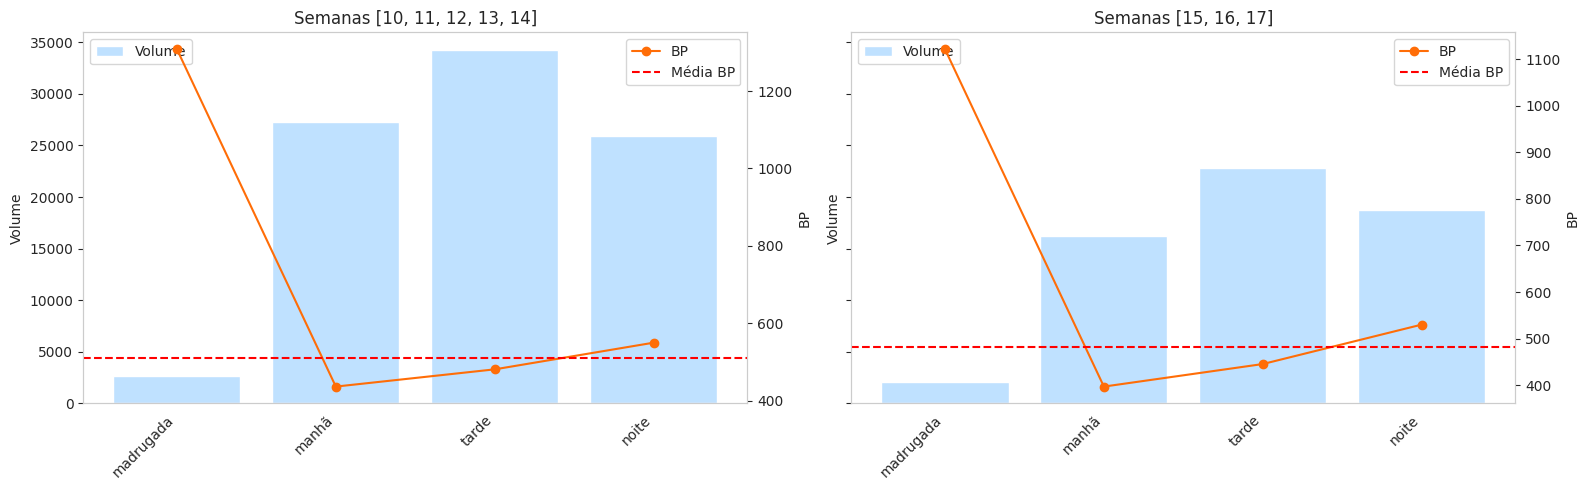

In [225]:
check_bad_var_compare(df, var='periodo', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=7)

In [226]:
df['periodo_numerica'] = df['periodo'].map({'madrugada':3, 'manhã':0, 'tarde':1, 'noite':2}).astype(int)

###### Análise de estabilidade X BP

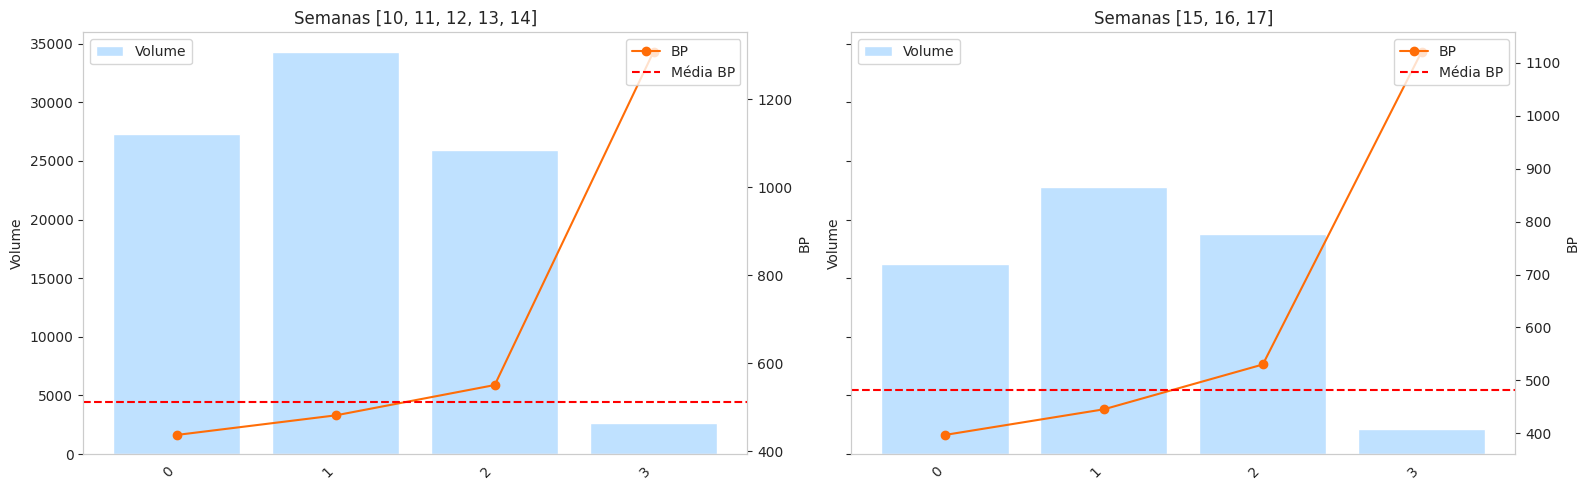

In [227]:
check_bad_var_compare(df, var='periodo_numerica', target='fraude', tipo='categorica',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True)

estável

**Observações**
* Variável fim de semana e período se mantém estáveis no OOT
* Final de semana cai a bad rate e durante a semana ela sobe
* Bad rate é maior de noite e madrugada
* A variável não tem nulos

---

**Comentários**
* Utilizar de forma numérica para aproveitar a crescente da bad rate da manha para a madrugada

#### Analisando a variável monto

##### Analise inicial

In [228]:
df.monto.head(5).reset_index().T

0       1       2     3     4
index  0.00    1.00    2.00  3.00  4.00
monto  5.64  124.71  339.32  3.54  3.53

In [229]:
df.monto.describe().reset_index().T

0          1          2     3     4      5        6        7
index     count       mean        std   min   25%    50%      75%      max
monto  150000.0  43.523134  91.557888  0.02  9.38  20.61  40.6925  3696.35

Aparenta ser numérica contínua e o valor do produto

##### Análise de nulos

In [230]:
df.monto.isna().sum()

0

sem nulos nulos

##### Análise de estabilidade X BP

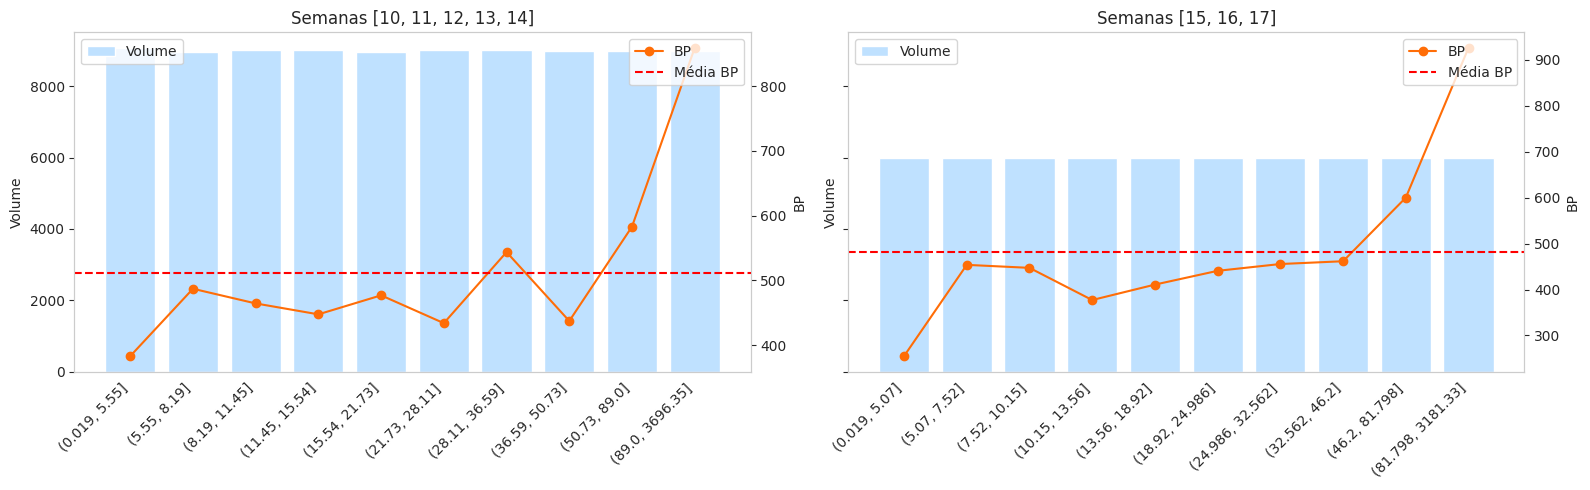

In [231]:
check_bad_var_compare(df, var='monto', target='fraude', tipo='num',
                      week_filter1=[10, 11, 12, 13, 14],
                      week_filter2=[15, 16, 17],
                      ascending=True,cut=10)

**Observações**
* Variável se demonstra estável na maioria dos bins no OOT tanto volume quanto bad rate
* Variável apresenta baixa bad-rate em valores muito baixos
* Variável apresenta alta bad-rate em valores muito altos
* A variável não tem nulos

---

**Comentários**
* Utilizar de forma numérica

In [232]:
df[['a','b_filled_pos','c','d','e','f', 'g_agrup_simples_num',
    'i_len','i_special_chars_agrup_num','i_num_count_agrup_num','i_word_original','i_word_kit','i_word_gb','i_word_ram',
    'j_cluster_agrup','k','l','m','n','o_fill_pos','p_num','is_weekend','periodo_numerica','monto',
    ]]

a  b_filled_pos          c     d         e      f  \
0       4        0.7685   94436.24  20.0  0.444828    1.0   
1       4        0.7550    9258.50   1.0  0.000000   33.0   
2       4        0.7455  242549.09   3.0  0.000000   19.0   
3       4        0.7631   18923.90  50.0  0.482385   18.0   
4       2        0.7315    5728.68  15.0  0.000000    1.0   
...    ..           ...        ...   ...       ...    ...   
149995  4        0.8191   21393.63   7.0  0.000000    1.0   
149996  4        1.1000        NaN  24.0  0.384615   11.0   
149997  4        1.1000        NaN   3.0  0.477778    1.0   
149998  4        0.6067  152906.86   1.0  0.099175  133.0   
149999  4        0.7546    7924.69   1.0  0.477778   80.0   

        g_agrup_simples_num  i_len  i_special_chars_agrup_num  \
0                         2     60                          2   
1                         2     60                          2   
2                         1     59                          0   
3                         2     57                          0   
4                         2     40                          0   
...                     ...    ...                        ...   
149995                    2     55                          3   
149996                    0     44                          2   
149997                    2     53                          3   
149998                    2     58                          1   
149999                    2     58                          1   

        i_num_count_agrup_num  i_word_original  i_word_kit  i_word_gb  \
0                           0                0           0          0   
1                           0                0           0          0   
2                           0                0           0          0   
3                           0                0           0          0   
4                           0                0           0          0   
...                       ...              ...         ...        ...   
149995                      0                0           0          0   
149996                      0                0           0          0   
149997                      1                0           0          0   
149998                      1                0           0          0   
149999                      0                0           0          0   

        i_word_ram  j_cluster_agrup         k       l       m  n  o_fill_pos  \
0                0                0  0.883598   240.0   102.0  1           2   
1                0                0  0.376019  4008.0     0.0  1           1   
2                0                0  0.516368  1779.0    77.0  1           2   
3                0                0  0.154036  1704.0  1147.0  1           2   
4                0                0  0.855798  1025.0   150.0  1           2   
...            ...              ...       ...     ...     ... ..         ...   
149995           0                0  0.808366  2009.0   434.0  1           2   
149996           0                0  0.989981   499.0   135.0  1           2   
149997           0                0  0.763939   127.0   127.0  1           2   
149998           0                0  0.382728  4373.0   123.0  1           2   
149999           0                0  0.627020  3495.0     0.0  1           2   

        p_num  is_weekend  periodo_numerica   monto  
0           0           0                 0    5.64  
1           0           0                 2  124.71  
2           0           0                 2  339.32  
3           1           0                 1    3.54  
4           0           0                 0    3.53  
...       ...         ...               ...     ...  
149995      0           1                 2   47.15  
149996      1           0                 2    9.69  
149997      1           0                 2    5.97  
149998      1           0                 0   25.83  
149999      0           0                 0    5.28  

[150000

#### Análise de correlações

<Axes: >

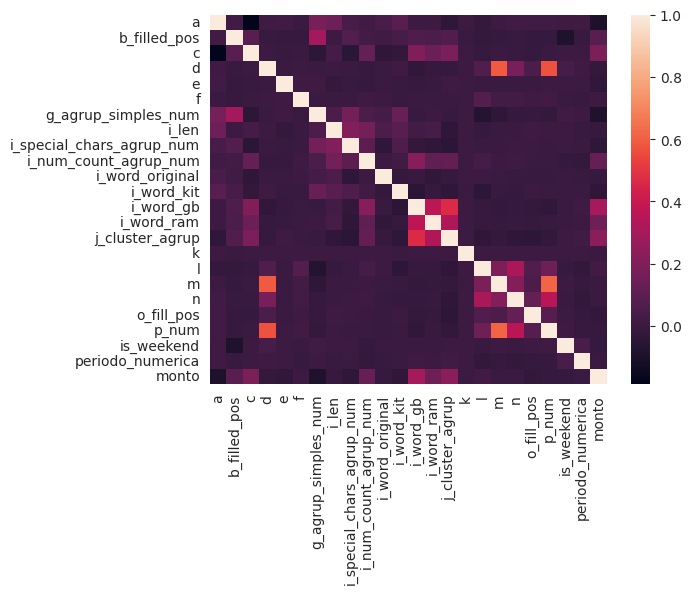

In [233]:
sns.heatmap(df[['a','b_filled_pos','c','d','e','f', 'g_agrup_simples_num','h',
    'i_len','i_special_chars_agrup_num','i_num_count_agrup_num','i_word_original','i_word_kit','i_word_gb','i_word_ram',
    'j_cluster_agrup','k','l','m','n','o_fill_pos','p_num','is_weekend','periodo_numerica','monto',
    ]].corr())